Epoch:  9
.TRAIN Accuracy-  0.18
.TRAIN Accuracy-  0.2
.TRAIN Accuracy-  0.26
.TRAIN Accuracy-  0.1
.TRAIN Accuracy-  0.28
.TRAIN Accuracy-  0.16
.TRAIN Accuracy-  0.18
.TRAIN Accuracy-  0.06
.TRAIN Accuracy-  0.18
.TRAIN Accuracy-  0.12
.TRAIN Accuracy-  0.3
.TRAIN Accuracy-  0.3
.TRAIN Accuracy-  0.22
.TRAIN Accuracy-  0.22
.TRAIN Accuracy-  0.14
.TRAIN Accuracy-  0.12
.TRAIN Accuracy-  0.16
.TRAIN Accuracy-  0.26
.TRAIN Accuracy-  0.24
.TRAIN Accuracy-  0.26
.TRAIN Accuracy-  0.22
.TRAIN Accuracy-  0.2
.TRAIN Accuracy-  0.34
.TRAIN Accuracy-  0.2
.TRAIN Accuracy-  0.22
.TRAIN Accuracy-  0.2
.TRAIN Accuracy-  0.22
.TRAIN Accuracy-  0.24
.TRAIN Accuracy-  0.18
.TRAIN Accuracy-  0.38
.TRAIN Accuracy-  0.2
.TRAIN Accuracy-  0.18
.TRAIN Accuracy-  0.24
.TRAIN Accuracy-  0.28
.TRAIN Accuracy-  0.22
.TRAIN Accuracy-  0.18
.TRAIN Accuracy-  0.28
.TRAIN Accuracy-  0.1
.TRAIN Accuracy-  0.16
.TRAIN Accuracy-  0.16
.TRAIN Accuracy-  0.26
.TRAIN Accuracy-  0.22
.TRAIN Accuracy-  0.18
.TRAIN Acc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:325: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


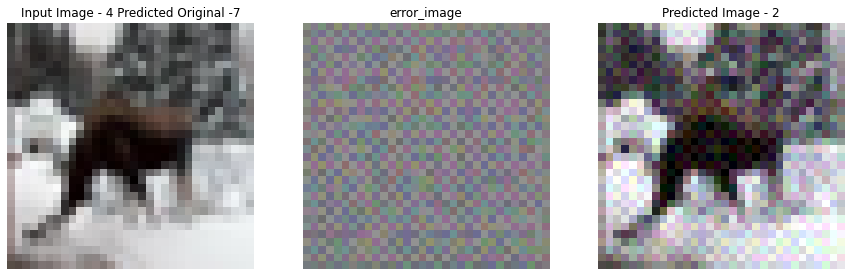

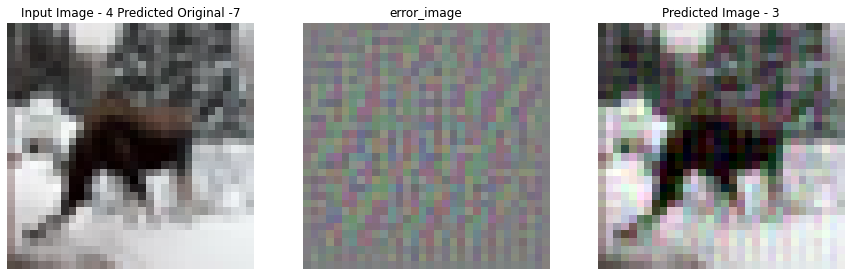

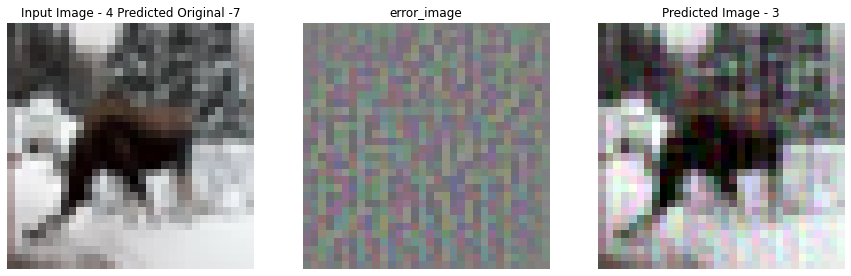

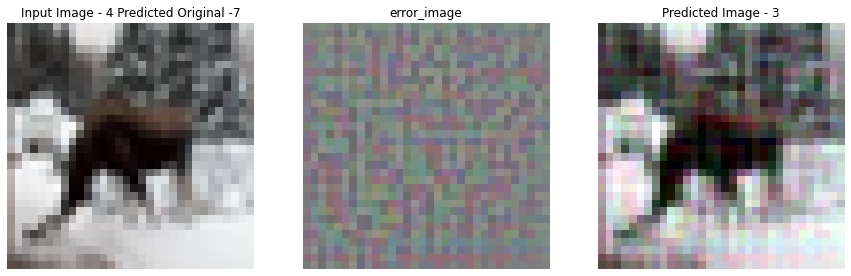

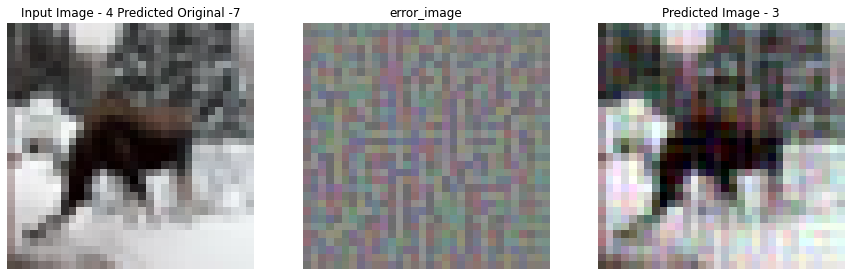

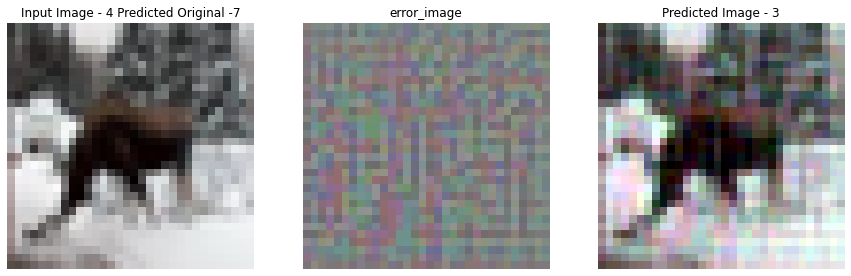

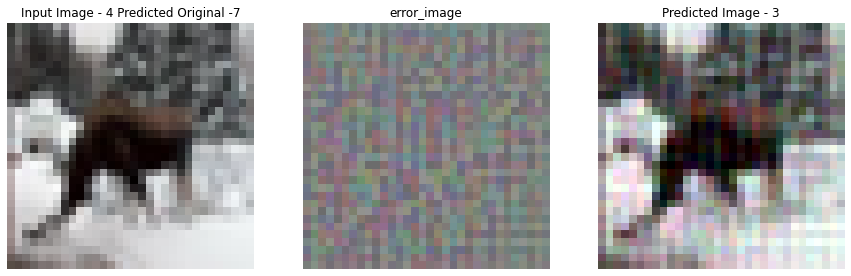

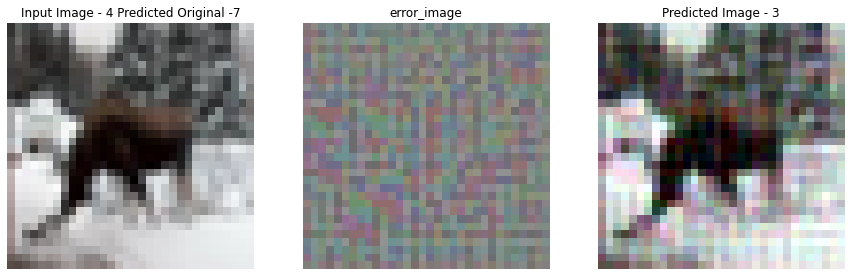

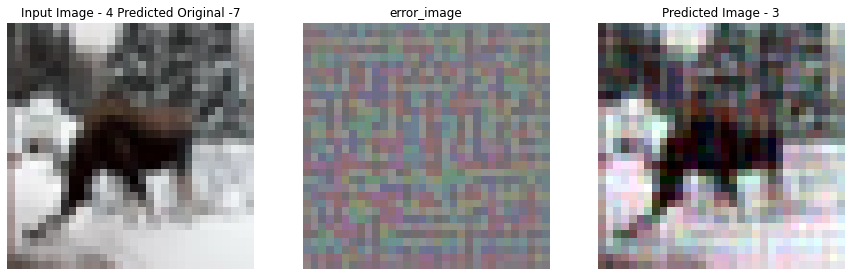

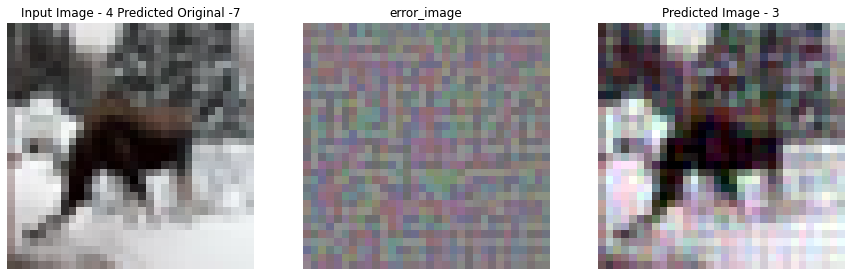

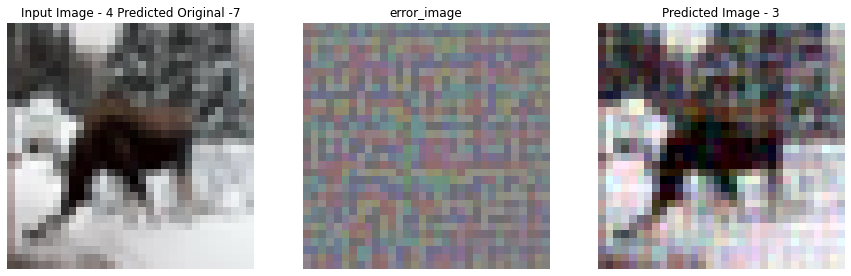

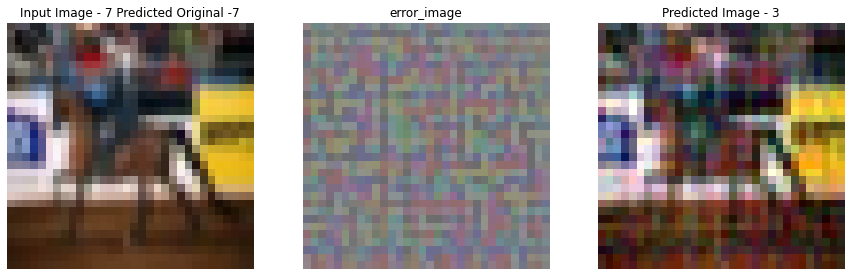

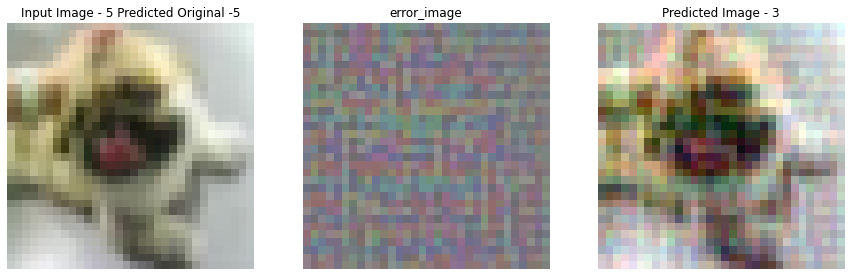

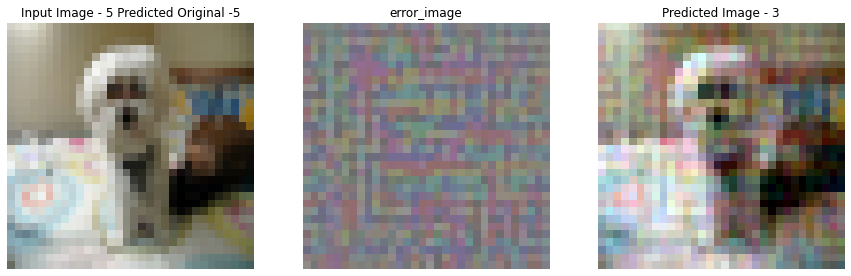

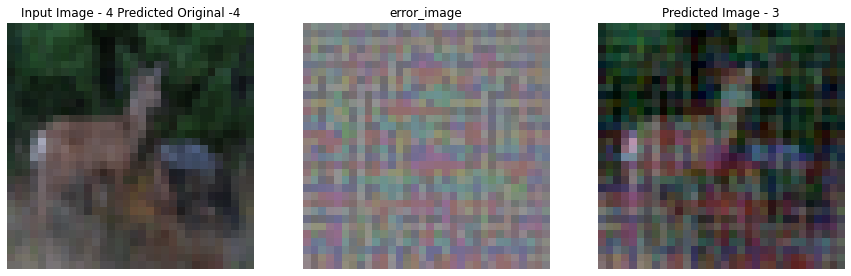

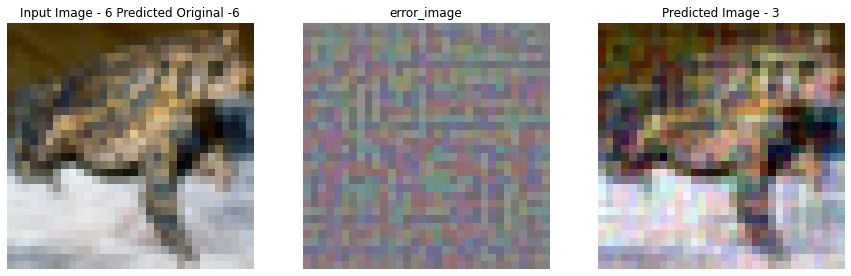

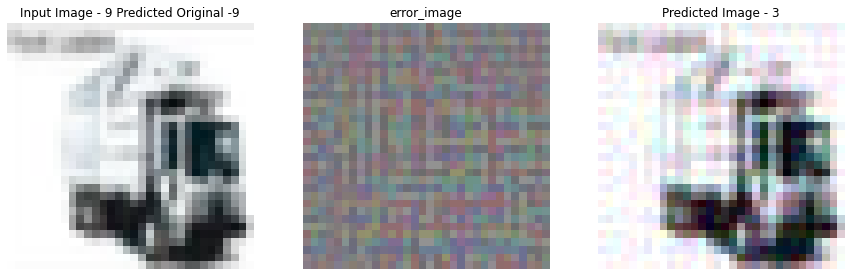

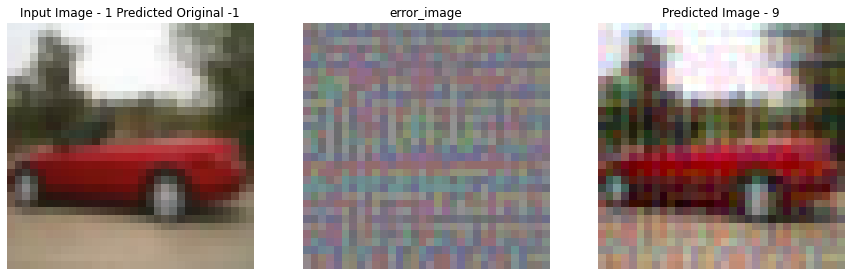

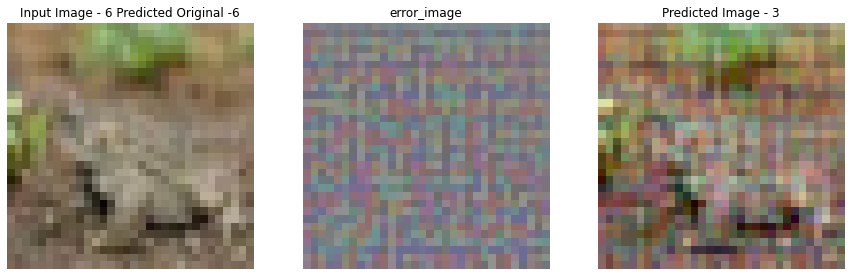

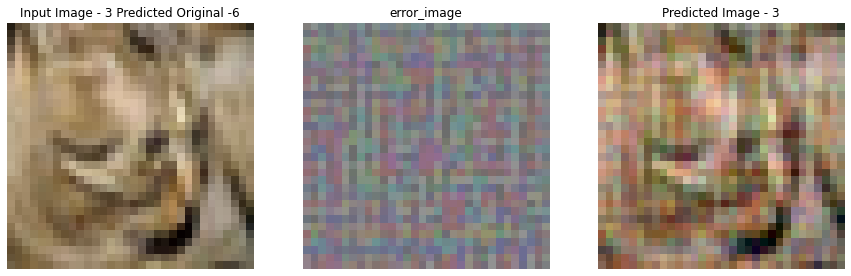

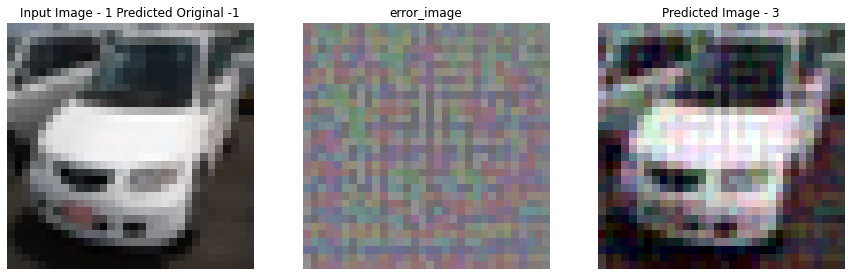

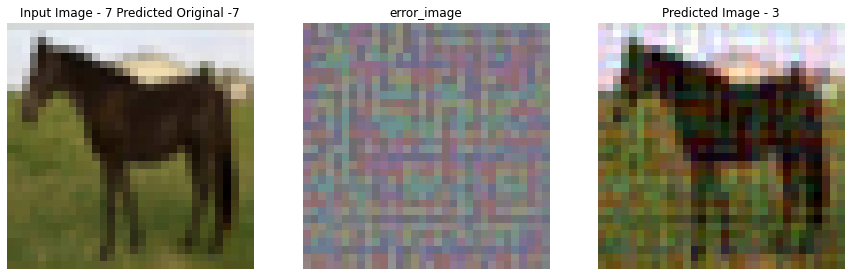

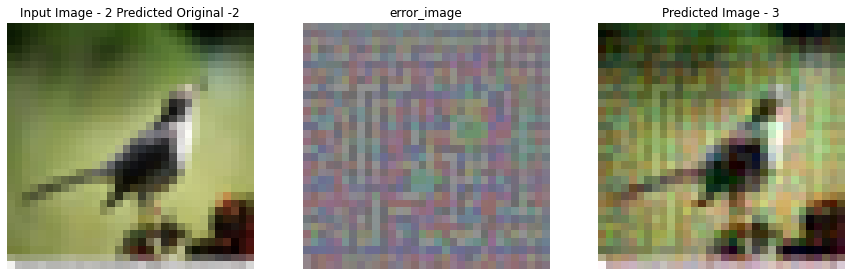

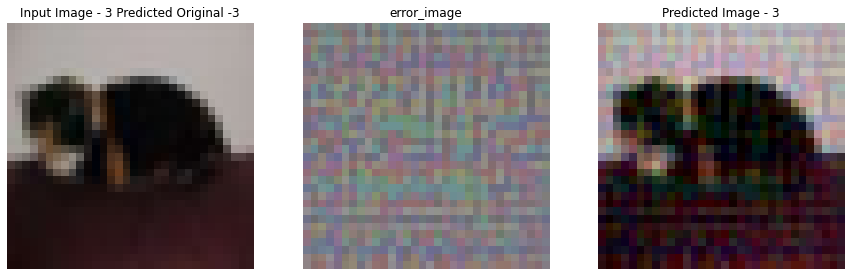

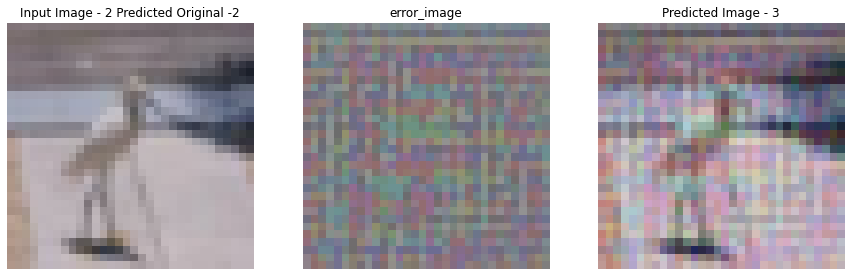

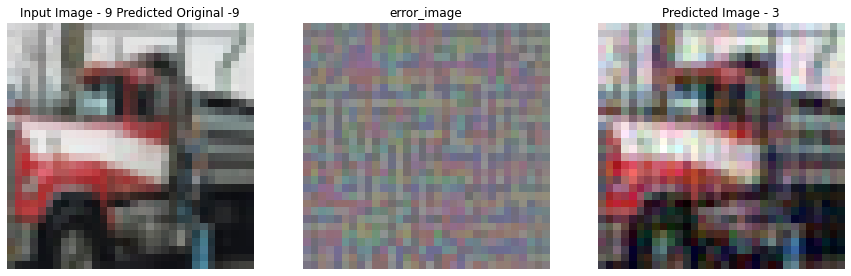

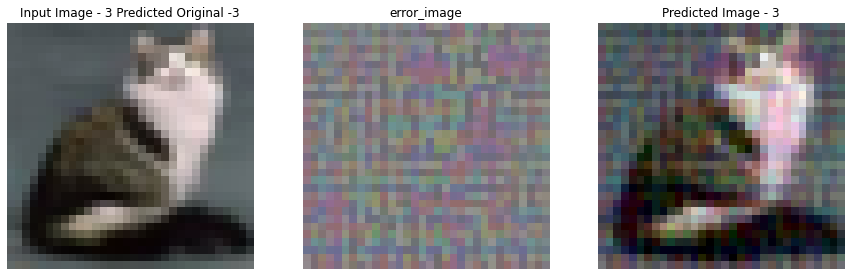

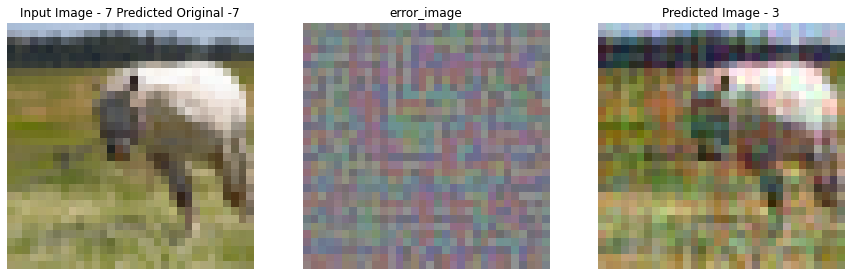

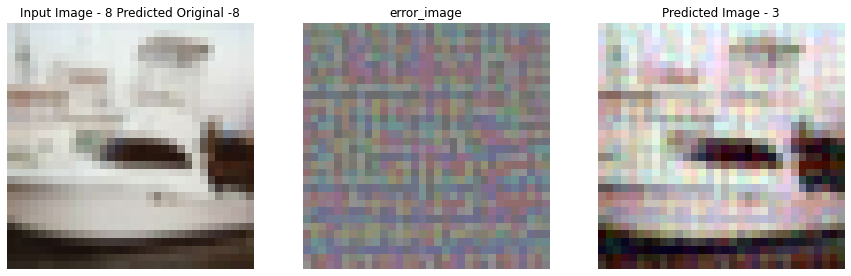

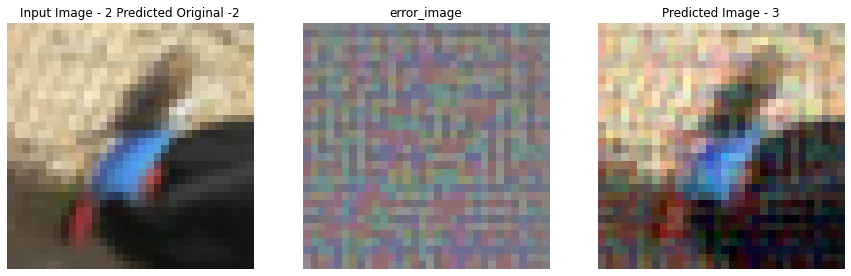

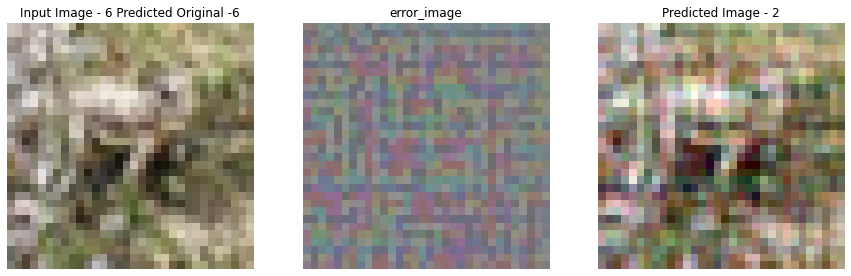

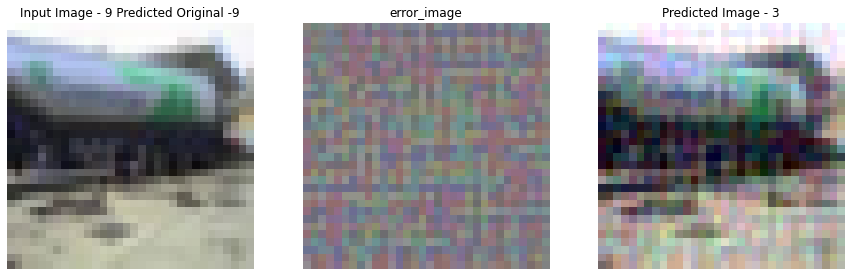

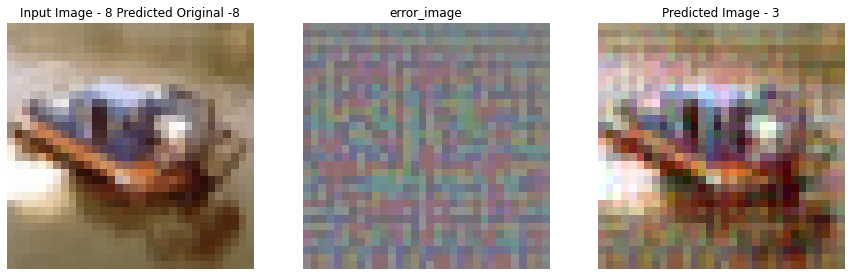

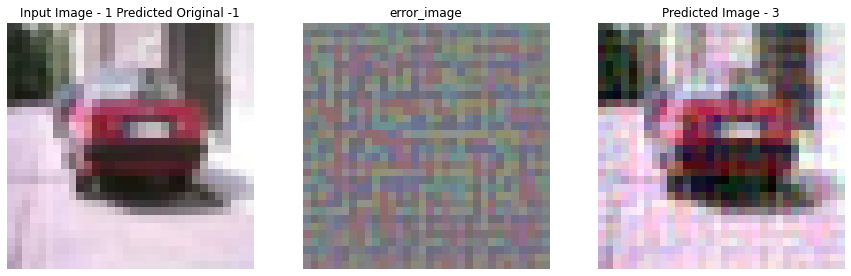

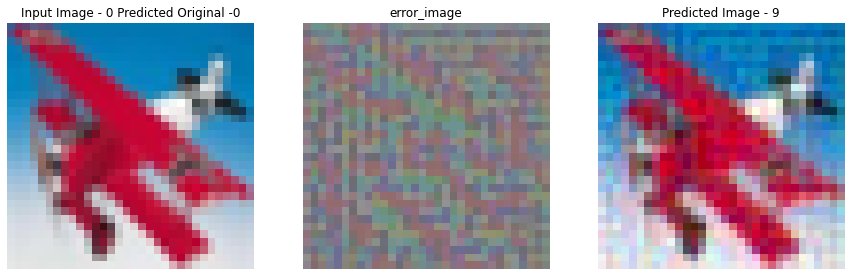

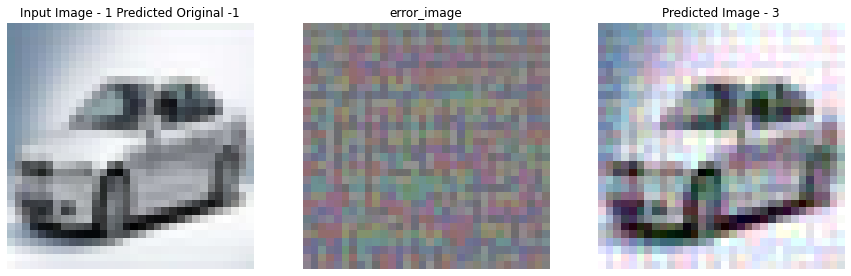

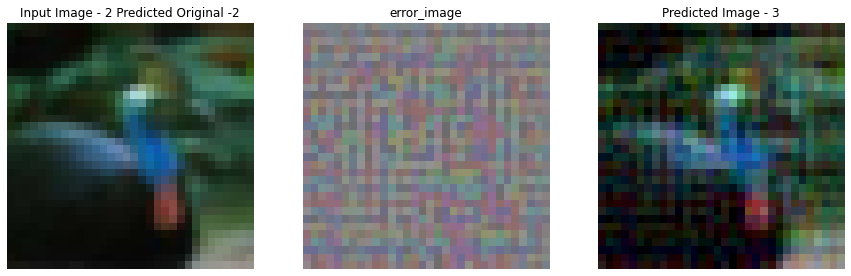

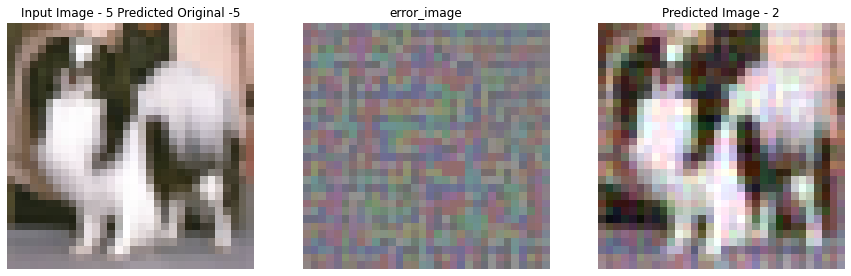

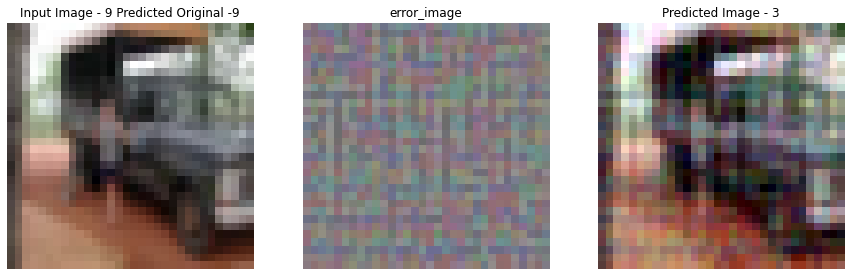

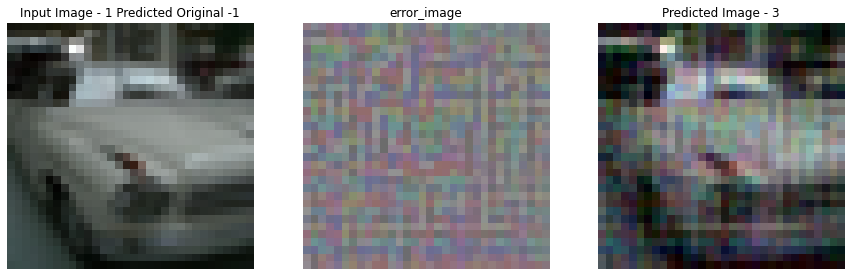

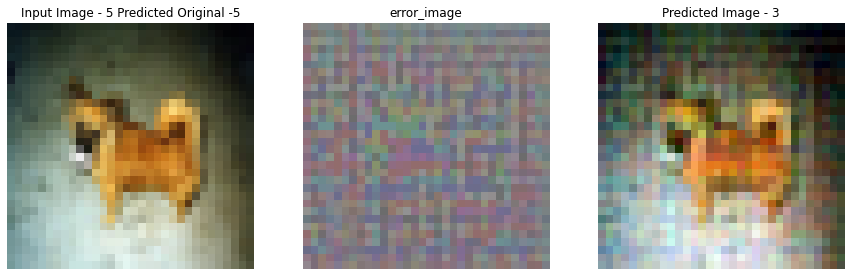

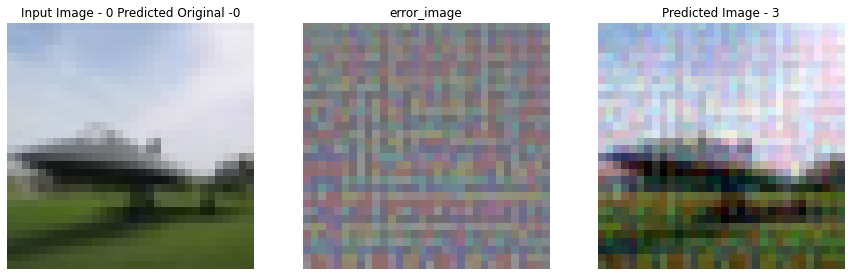

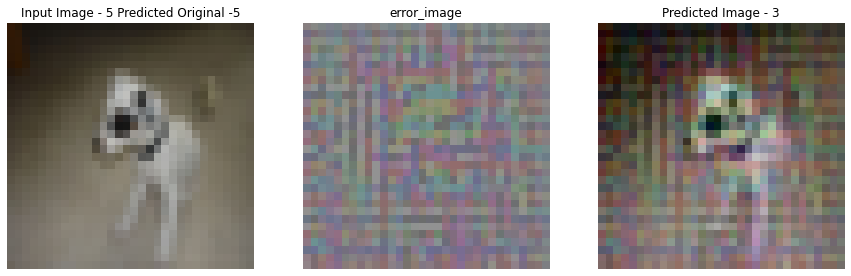

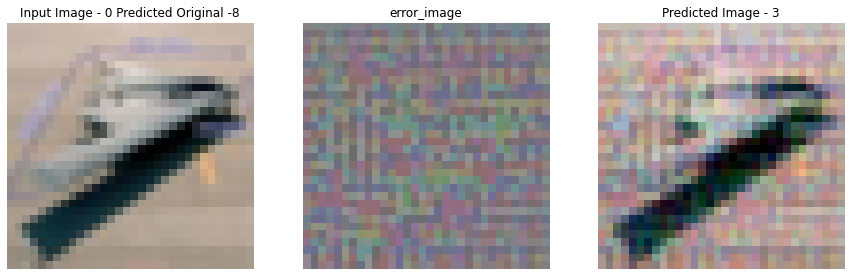

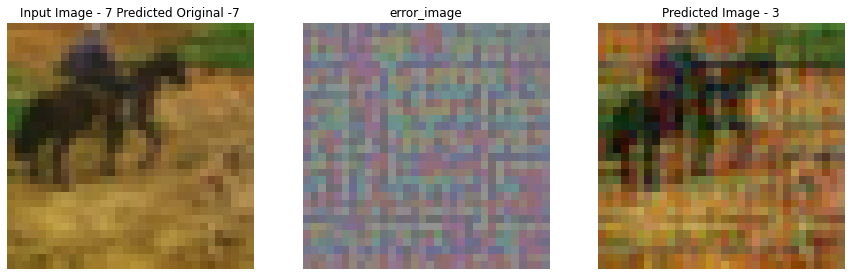

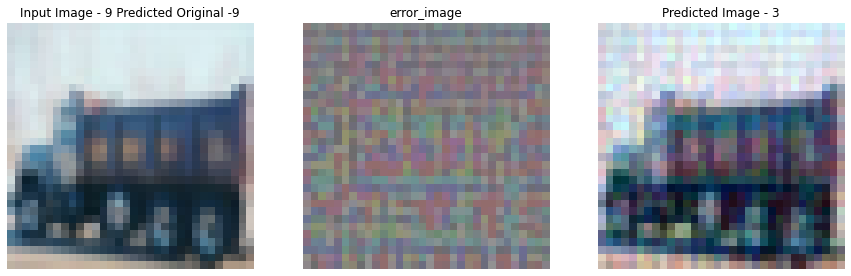

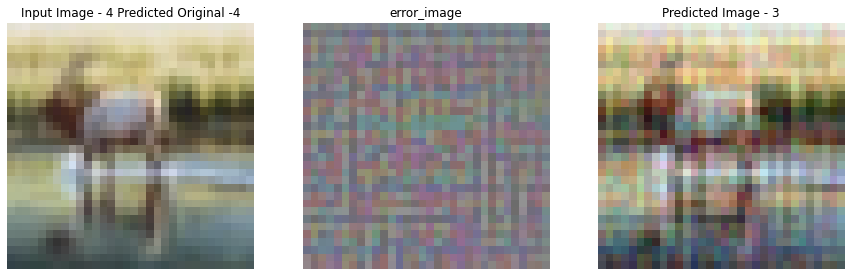

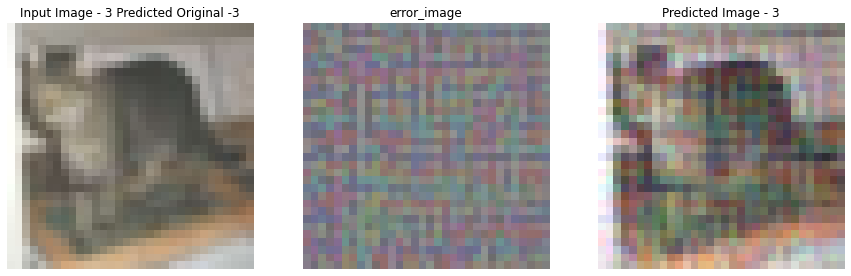

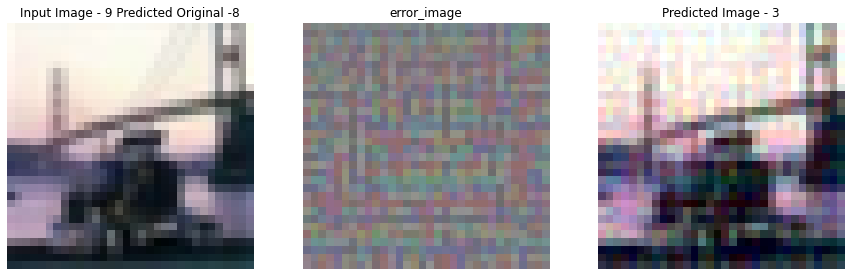

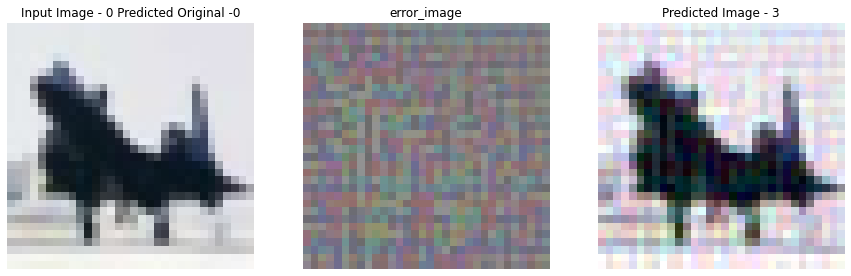

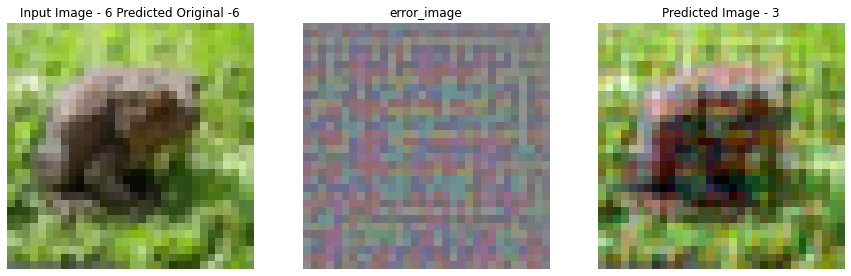

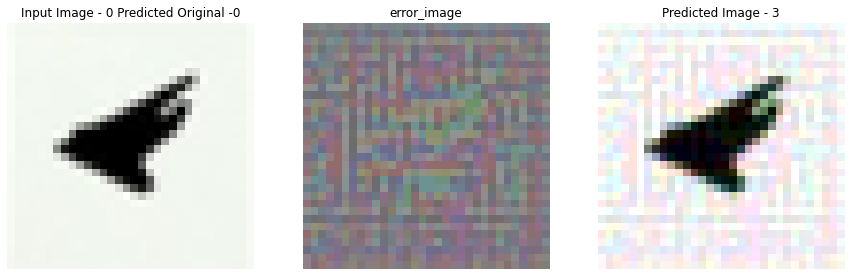

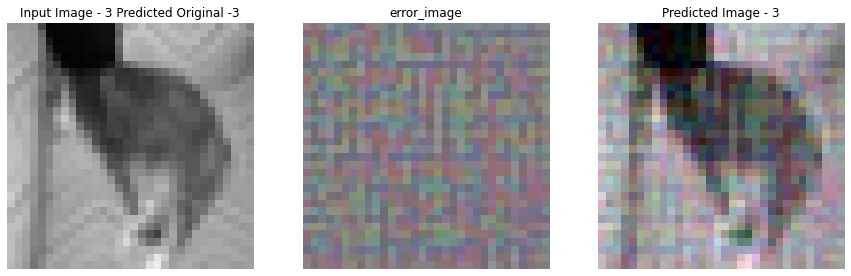

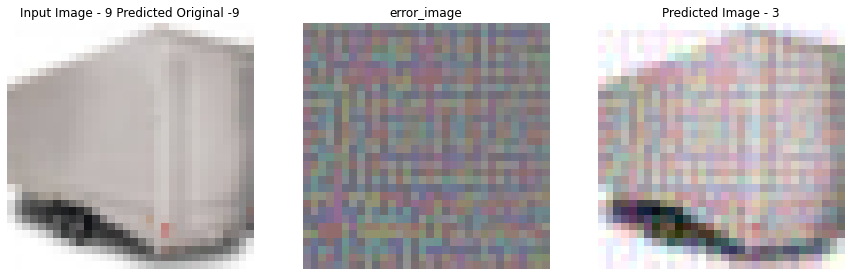

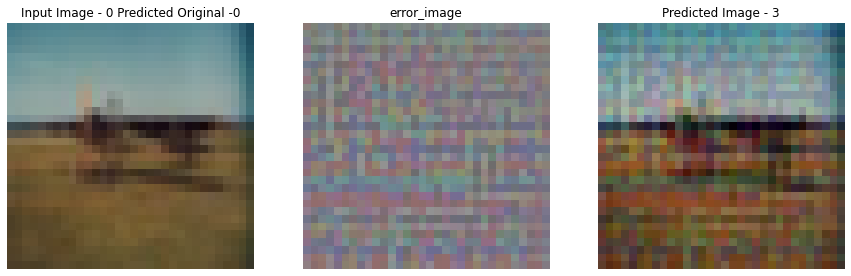

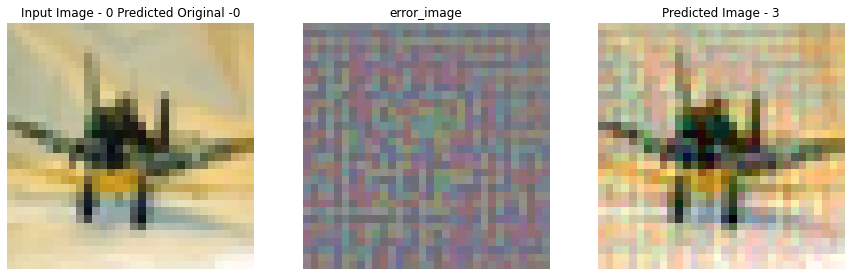

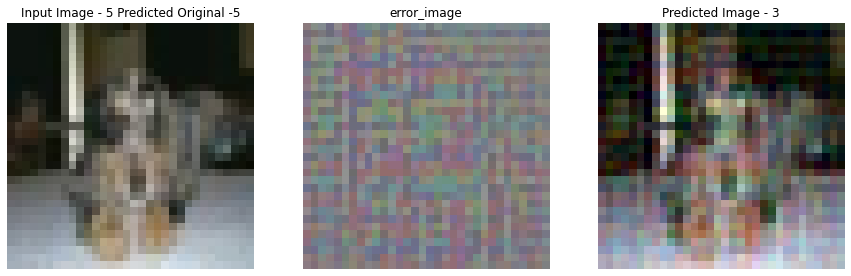

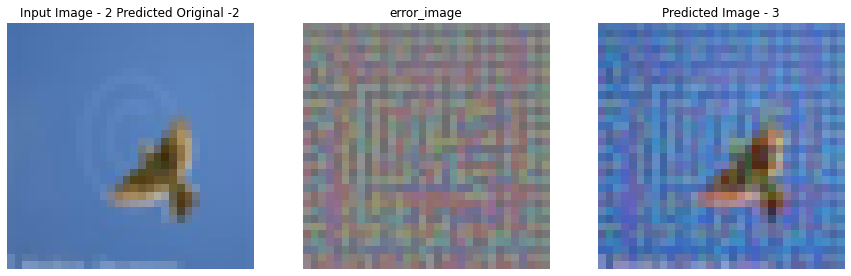

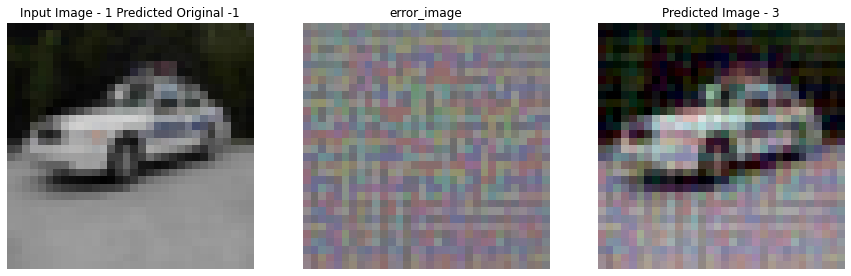

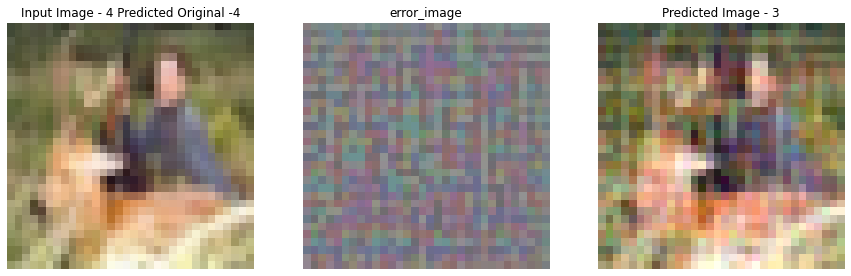

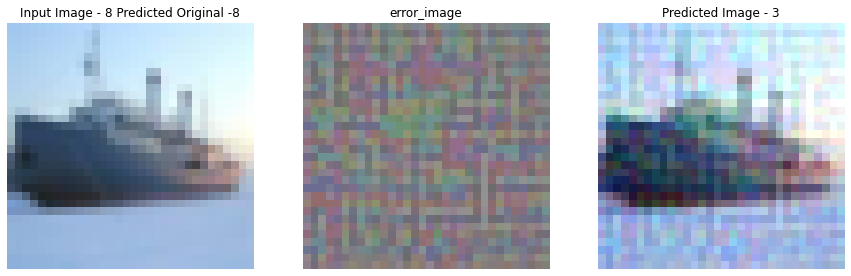

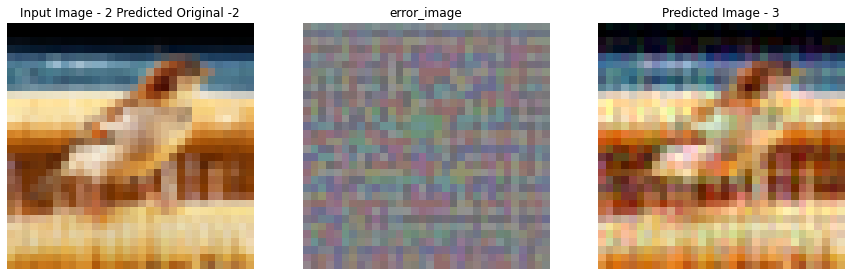

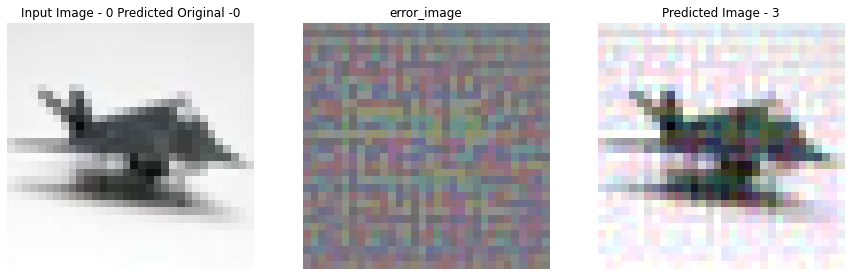

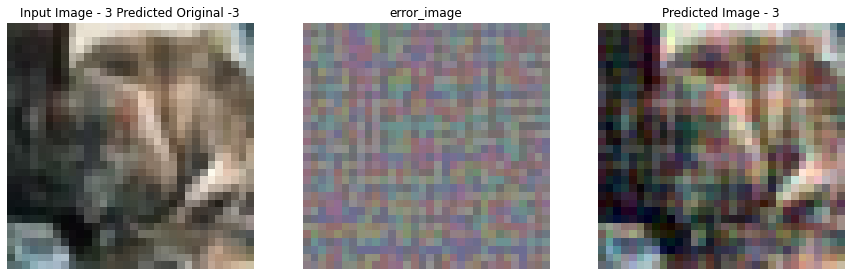

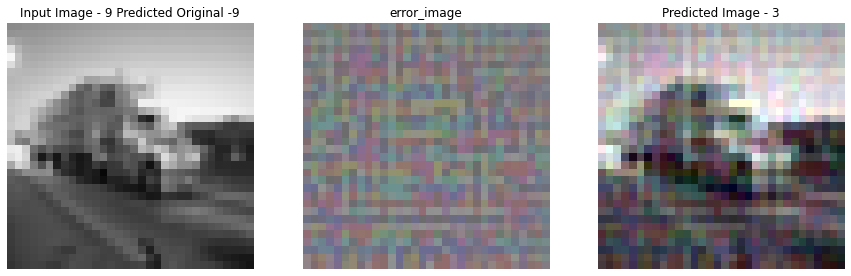

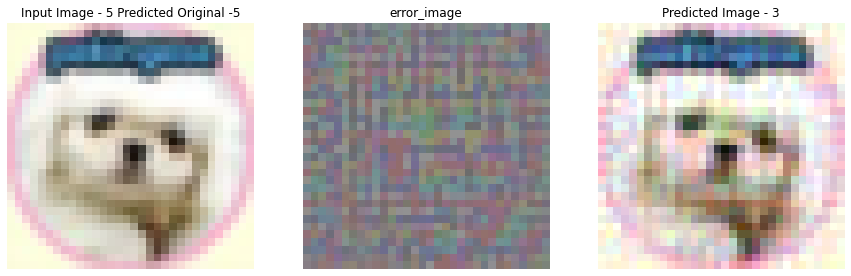

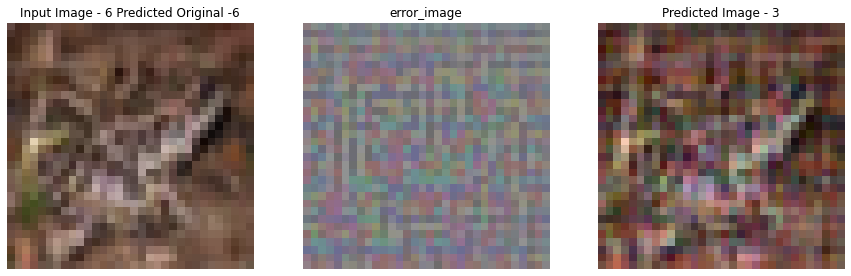

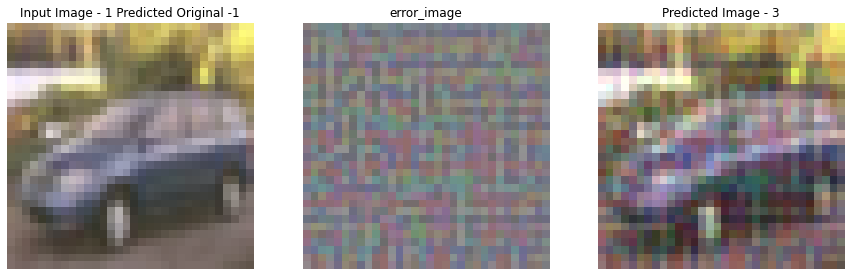

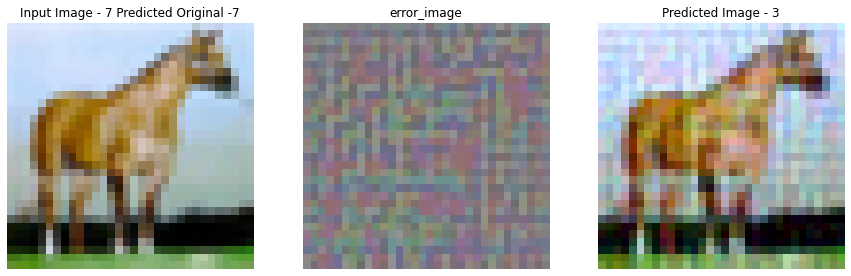

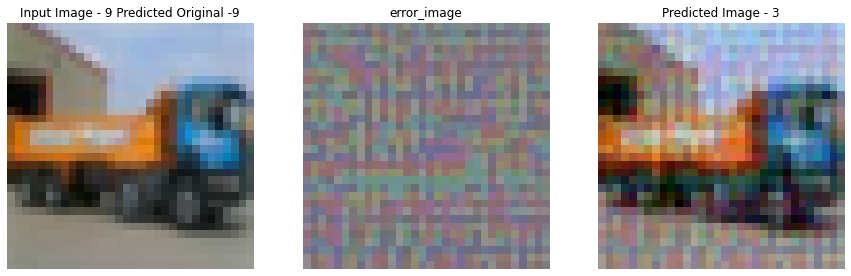

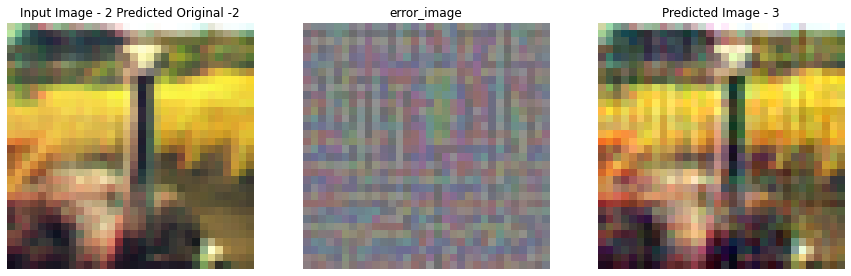

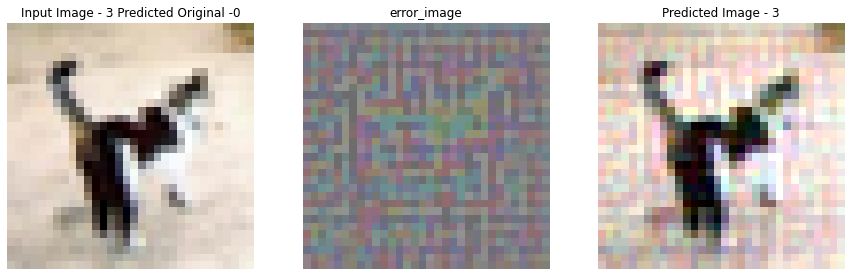

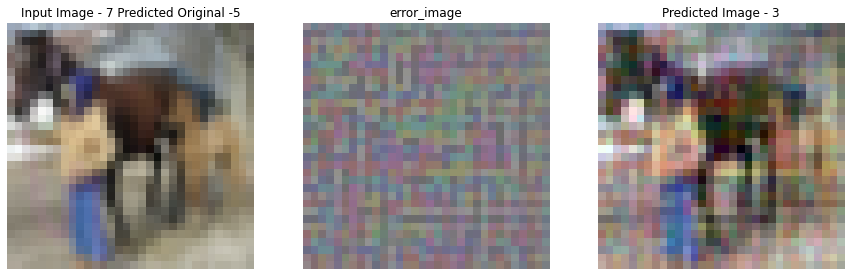

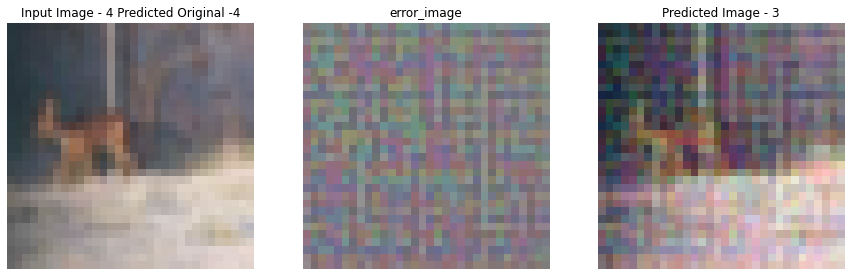

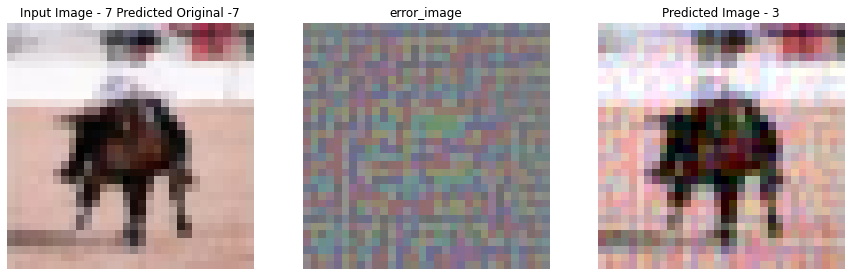

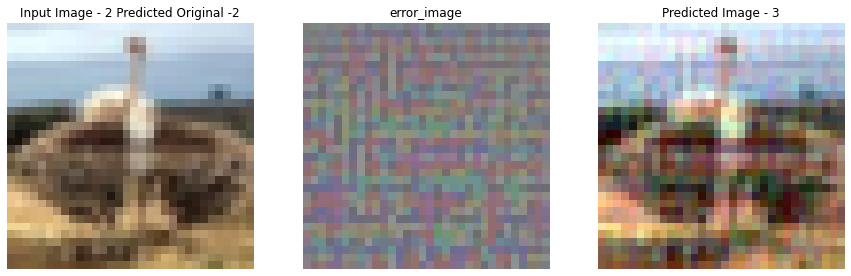

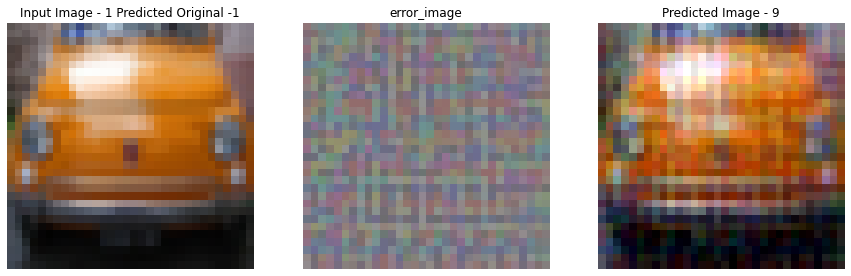

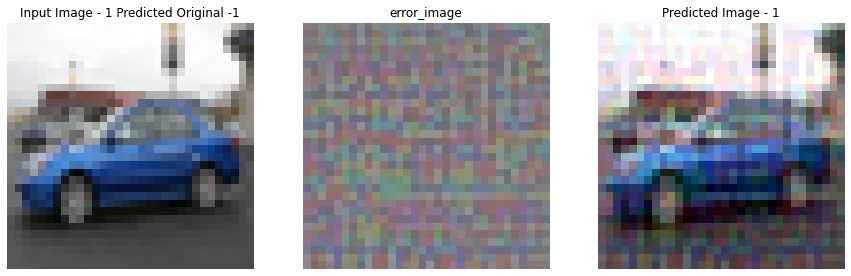

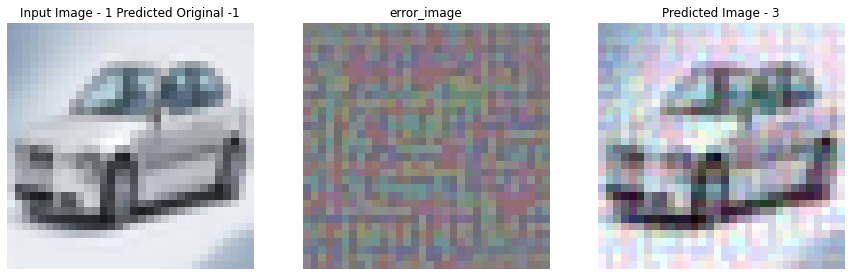

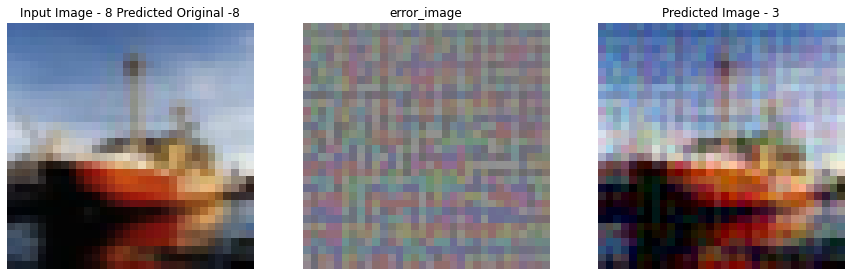

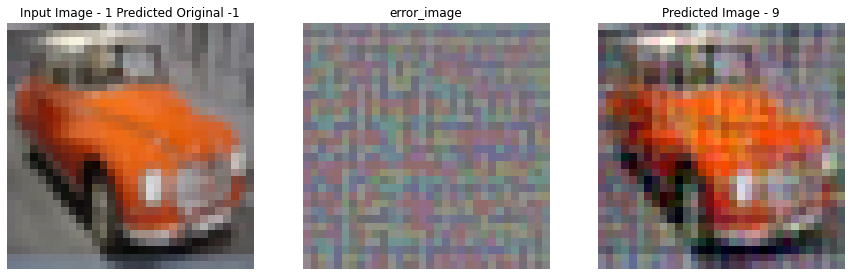

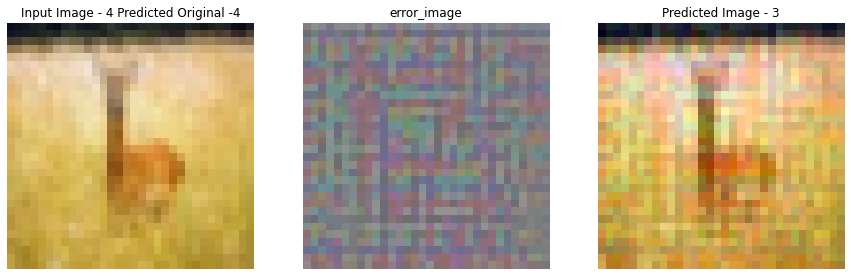

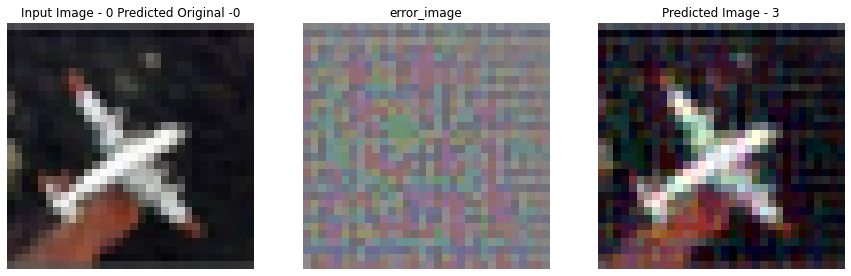

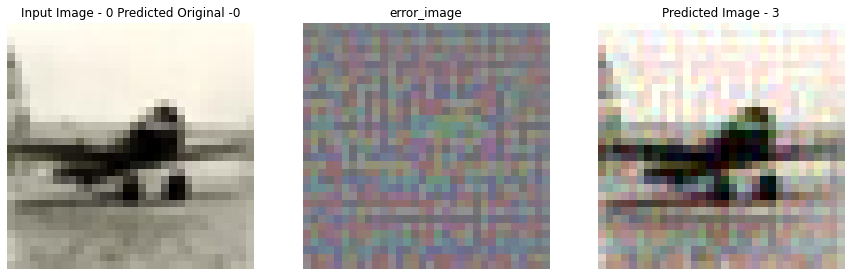

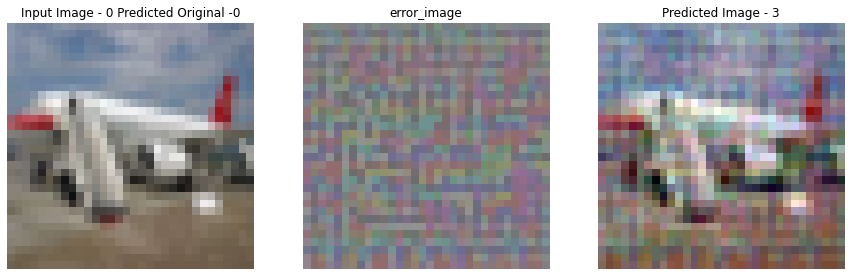

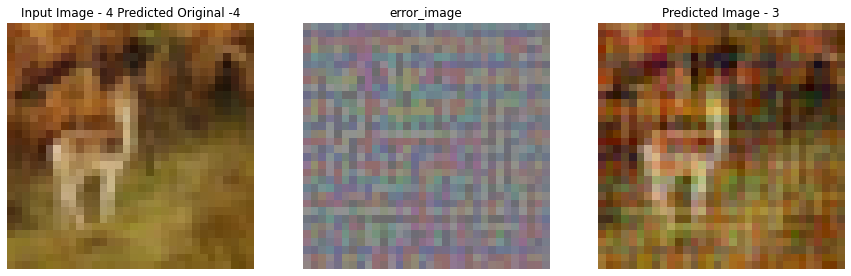

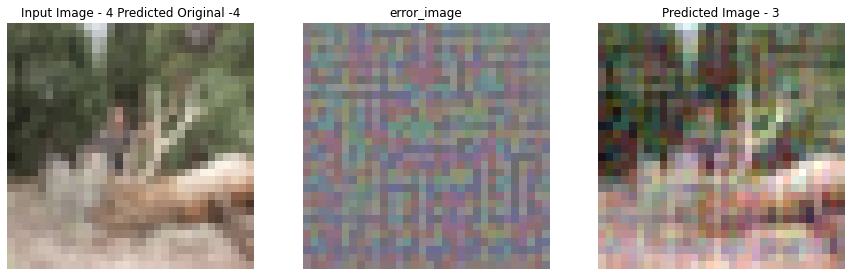

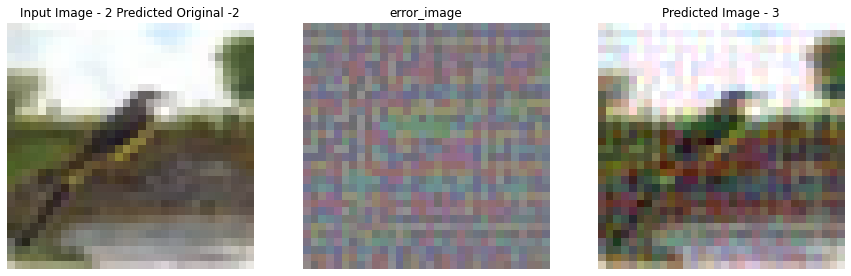

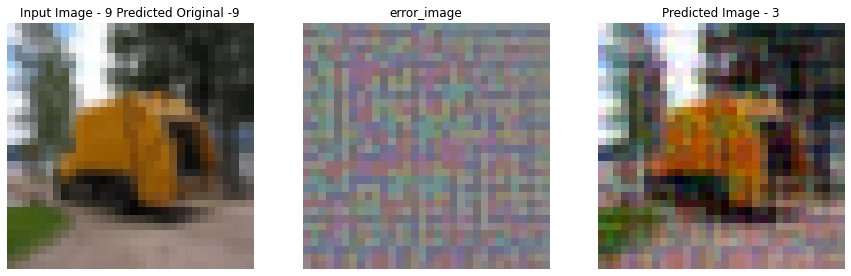

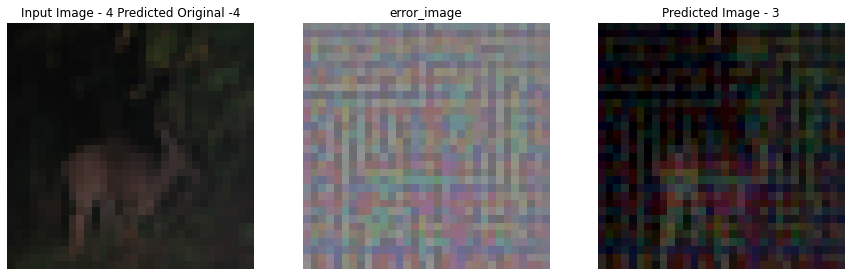

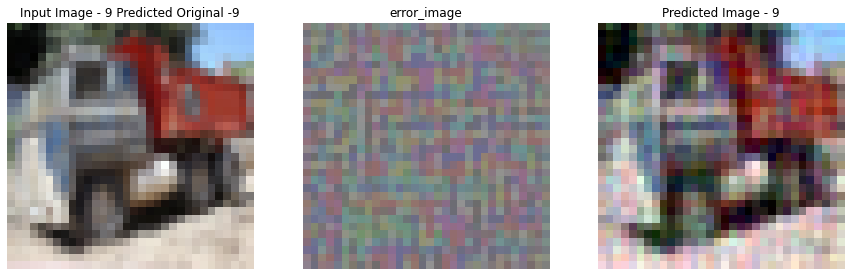

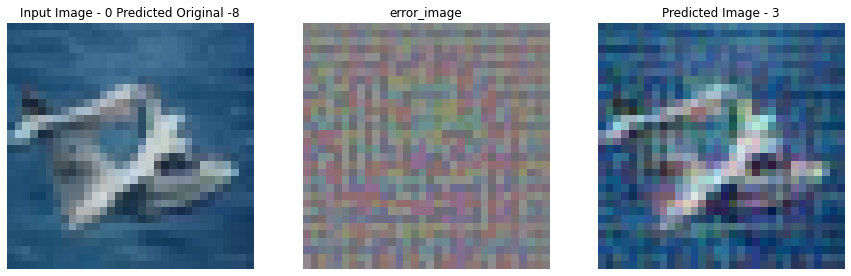

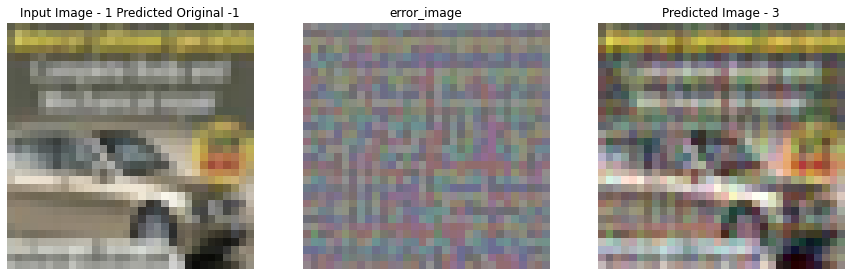

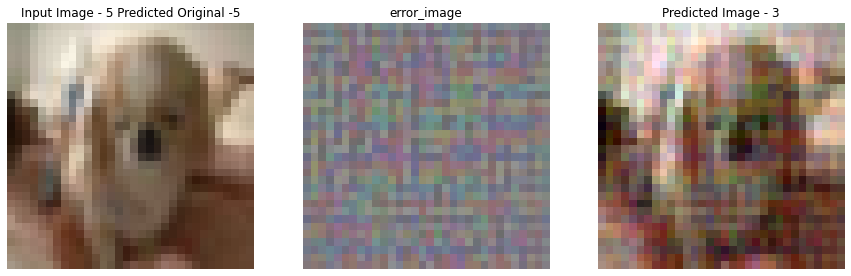

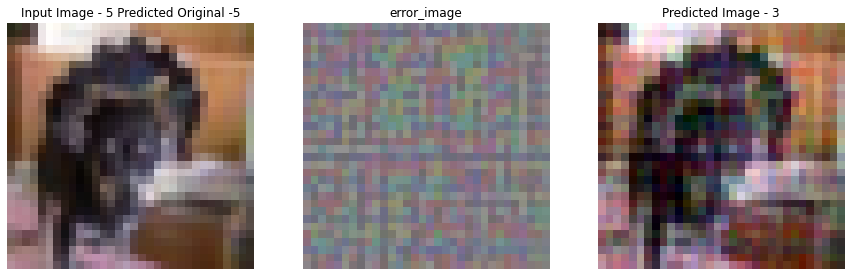

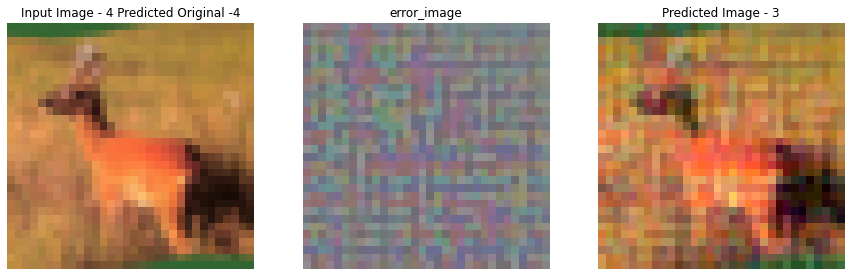

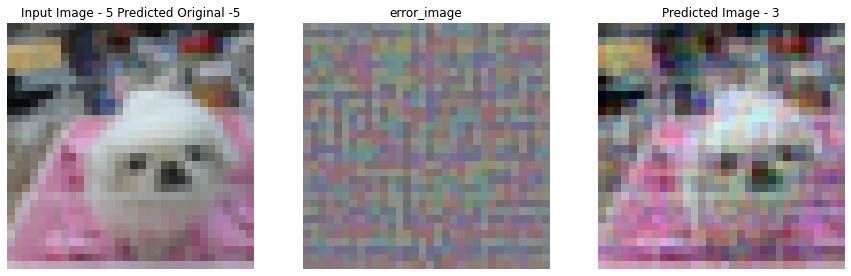

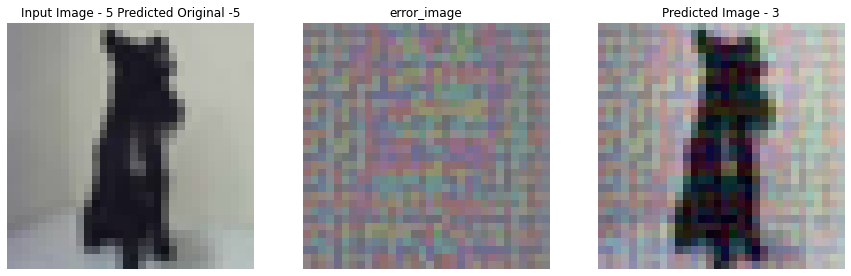

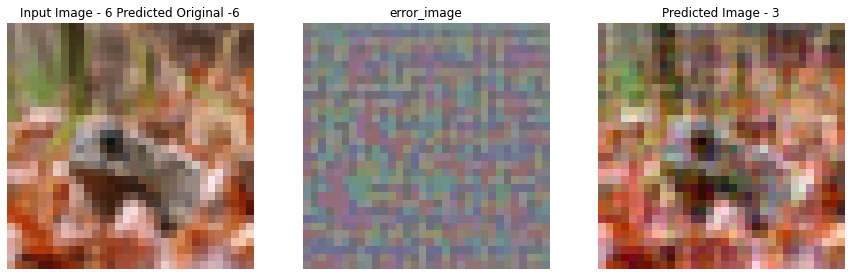

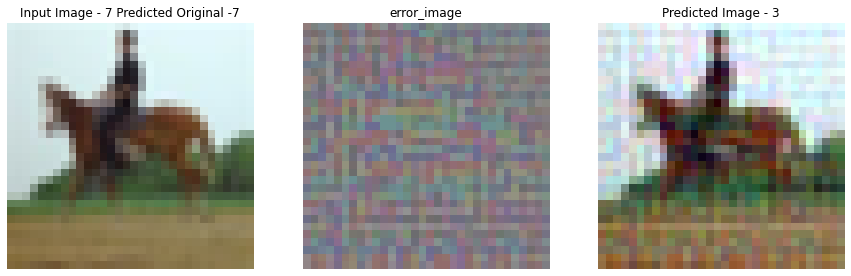

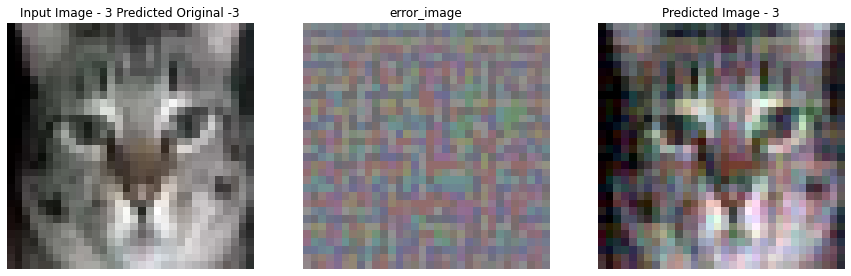

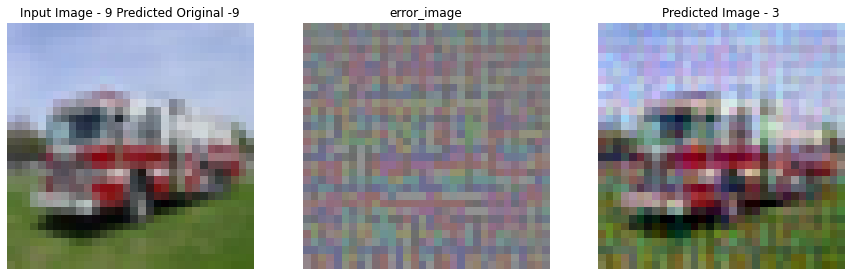

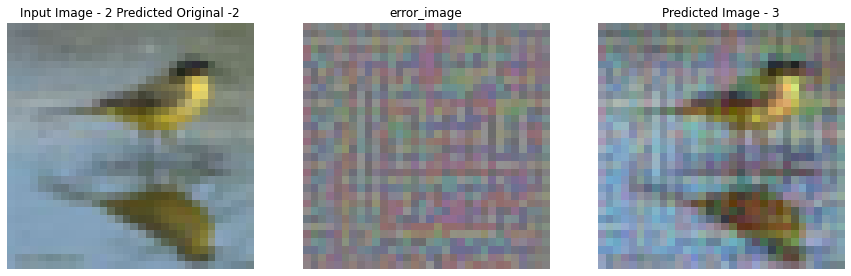

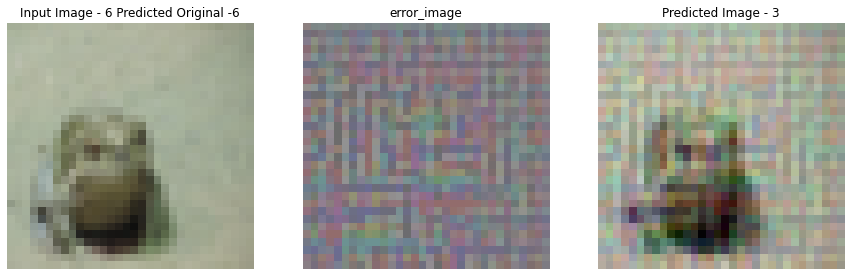

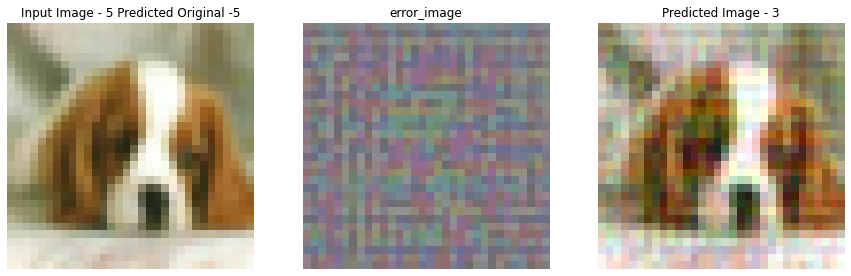

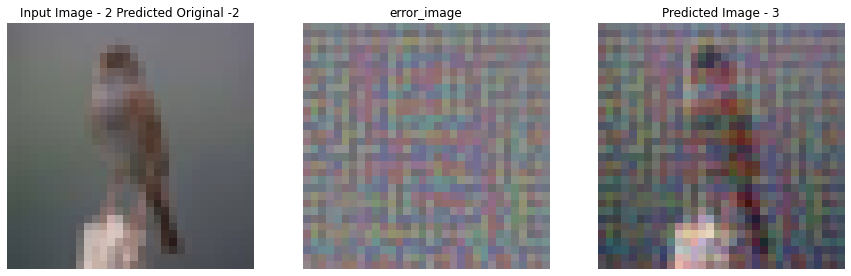

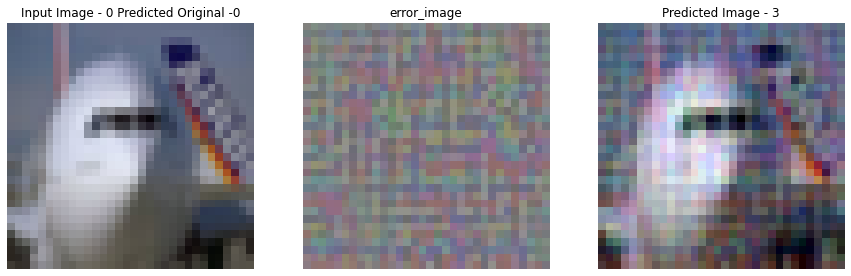

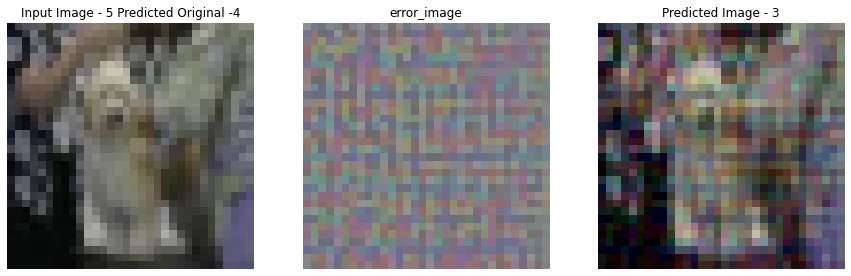

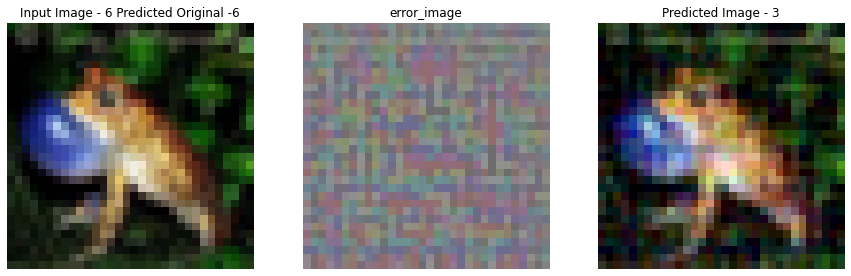

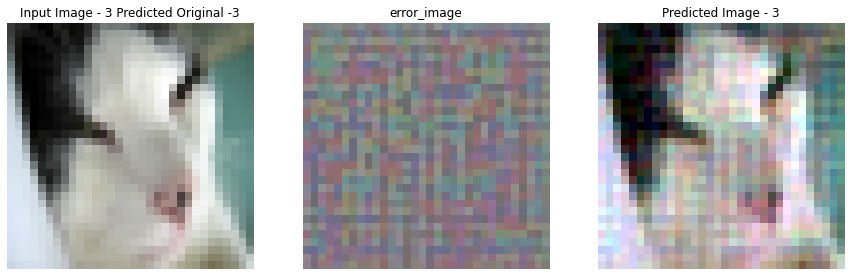

In [12]:
#!git clone https://github.com/iSarmad/RL-GAN-Net.git
# from google.colab import drive                                                                                                                                                                        
# drive.mount('/content/gdrive')
# %cd gdrive/My\ Drive/RL\ Project/CIFAR/CIFAR_Error

# !ls 


import tensorflow as tf
import os
import time

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf


from matplotlib import pyplot as plt
from IPython import display
import numpy as np




BUFFER_SIZE = 60000
BATCH_SIZE = 50
LAMBDA = 140
X=0

EPOCHS = 10
THRESH=0.15


# def create_target_model():
#   conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
#   model = models.Sequential()
#   model.add(layers.UpSampling2D((2,2)))
#   model.add(layers.UpSampling2D((2,2)))
#   model.add(layers.UpSampling2D((2,2)))
#   model.add(conv_base)
#   model.add(layers.Flatten())
#   model.add(layers.BatchNormalization())
#   model.add(layers.Dense(128, activation='relu'))
#   model.add(layers.Dropout(0.5))
#   model.add(layers.BatchNormalization())
#   model.add(layers.Dense(64, activation='relu'))
#   model.add(layers.Dropout(0.5))
#   model.add(layers.BatchNormalization())
#   model.add(layers.Dense(10, activation='softmax'))

#   model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
#   return model


target_model=tf.keras.models.load_model('resnet56.h5')


(train_dataset, train_labels), (test_dataset, test_labels) = tf.keras.datasets.cifar10.load_data()

train_dataset = train_dataset.reshape(train_dataset.shape[0], 32, 32, 3).astype('float32')
train_dataset = (train_dataset - 127.5) / 127.5
perm=np.random.permutation(train_dataset.shape[0])
train_dataset=train_dataset[perm]
train_labels=train_labels[perm]
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
train_dataset=tf.data.Dataset.from_tensor_slices((train_dataset,train_labels))
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = test_dataset.reshape(test_dataset.shape[0], 32, 32, 3).astype('float32')
test_dataset = (test_dataset - 127.5) / 127.5
# test_dataset=test_dataset/255

perm=np.random.permutation(test_dataset.shape[0])
test_dataset=test_dataset[perm]
test_labels=test_labels[perm]
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

print(test_dataset.shape)
print(test_labels.shape)
# target_model = create_target_model()
# target_model.fit(test_dataset[0:2],test_labels[0:2], epochs=1, batch_size=20)
# target_model.set_weights(t.get_weights())


print(target_model.evaluate(test_dataset,test_labels))


test_dataset=tf.data.Dataset.from_tensor_slices((test_dataset,test_labels))
# test_dataset = test_dataset.batch(BATCH_SIZE)

"""## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).
"""




OUTPUT_CHANNELS = 3




def downsample(filters, size, stride=2, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=stride, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

# down_model = downsample(3, 4)
# down_result = down_model(tf.expand_dims(inp, 0))
# print (down_result.shape)

def upsample(filters, size, stride=2, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=stride,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.3))

  result.add(tf.keras.layers.ReLU())

  return result

# up_model = upsample(3, 4)
# up_result = up_model(down_result)
# print (up_result.shape)

def Generator():
  inputs = tf.keras.layers.Input(shape=[32,32,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    # downsample(512, 4), # (bs, 4, 4, 512)
    # downsample(512, 4), # (bs, 2, 2, 512)
    # downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    # upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    # upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    # upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  error = last(x)
  error = tf.clip_by_value(error,-THRESH,THRESH)

  x = error + inputs
  x=tf.clip_by_value(x,-1,1)

  return tf.keras.Model(inputs=inputs, outputs=[x,error])

generator = Generator()
tf.keras.utils.plot_model(generator, to_file='generator.png',show_shapes=True, dpi=64)

# gen_output = generator(inp[tf.newaxis,...], training=False)
# plt.imshow(gen_output[0,...])

"""* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).
The training procedure for the generator is shown below:
"""

def adv_loss(preds, labels, is_targeted):
  real = tf.math.reduce_sum(labels * preds, 1)
  other = tf.math.reduce_max((1 - labels) * preds - (labels * 10000), 1)
  if is_targeted:
    return tf.math.reduce_sum(tf.math.maximum(0.0, other - real))
  return tf.math.reduce_sum(tf.maximum(0.0, real - other))


def generator_loss(disc_generated_output, gen_output, target, error,pred,label):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  l_adv = adv_loss(pred,label,False)
  l_perturb = perturb_loss(error)
  total_gan_loss = l_adv + gan_loss + (LAMBDA * l1_loss) + (5*l_perturb)
  return total_gan_loss, gan_loss, l1_loss,l_adv

def perturb_loss(preds, thresh=THRESH):
	zeros = tf.zeros((tf.shape(preds)[0]))
	return tf.math.reduce_mean(tf.math.maximum(zeros, tf.norm(tf.reshape(preds, (tf.shape(preds)[0], -1)), axis=1) - thresh))


def Discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32))
    model.add(tf.keras.layers.Dense(1))

    return model

discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, to_file='disriminator.png',show_shapes=True, dpi=64)

# disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
# plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
# plt.colorbar()

"""**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss
"""

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss





"""The training procedure for the discriminator is shown below.
To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).
![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)
## Define the Optimizers and Checkpoint-saver
"""
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = './AdvGANs_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

"""## Generate Images
Write a function to plot some images during training.
* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**
Note: The `training=True` is intentional here since
we want the batch statistics while running the model
on the test dataset. If we use training=False, we will get
the accumulated statistics learned from the training dataset
(which we don't want)
"""

def generate_images(model,test_input,t,a,b):
  test_input=tf.reshape(test_input,[1,32,32,3])
  prediction,error_image = model(test_input, training=True)
  pred_fake=np.argmax(target_model.predict(prediction))
  pred_orig=np.argmax(target_model.predict(test_input))
  t=np.argmax(t)
  # print(pred)
  # print(t)
  # pred=target_model.predict(prediction)
  # (loss, accuracy)=target_model.evaluate(prediction, t, batch_size = 128, verbose = 1)
  plt.figure(figsize=(15,15))
  display_list = [test_input,error_image, prediction]
  title = ['Input Image - ' + str(t)+' Predicted Original -'+str(pred_orig) ,'error_image' , 'Predicted Image - '+ str(pred_fake)]
  # print("TEST Accuracy- ",accuracy)
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(tf.reshape(display_list[i],[32,32,3]) * 0.5 + 0.5)
    plt.axis('off')
  if(a=='train'):
    plt.savefig('output_images_2/train_'+str(b)+'.png')
  elif(a=='test'):
    plt.savefig('output_images_2/test_'+str(b)+'.png')

# for example_input in test_dataset.take(1):
#   generate_images(generator, example_input)

"""## Training
* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.
"""


import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

@tf.function
def train_step(dataset, epoch,target_model):
  input_image=dataset[0]
  t=dataset[1]
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output,error_image = generator(input_image, training=True)

    disc_real_output = discriminator(input_image, training=True)
    disc_generated_output = discriminator( gen_output, training=True)
    pred=gen_output
    pred=target_model(pred)
    # for layer in target_model.layers:
    #   pred = layer(pred)
    #   print(pred.shape)
    #   print(layer)
    # pred=target_model.predict(pred,steps=1)
    # (loss, accuracy)=target_model.evaluate(gen_output, t, batch_size = 128, verbose = 1,steps=1)
    correct_prediction = tf.math.equal(tf.math.argmax(pred, 1), tf.math.argmax(t, 1))
    accuracy = tf.math.reduce_mean(tf.cast(correct_prediction, "float"))
    tf.print("TRAIN Accuracy- ",accuracy)
    gen_total_loss, gen_gan_loss, gen_l1_loss,l_adv = generator_loss(disc_generated_output, gen_output, input_image,error_image,pred,t)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
  

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))



"""The actual training loop:
* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.
"""

def fit(train_ds, epochs, test_ds,target_model):
  for epoch in range(epochs):
    
    start = time.time()
    if(epoch>=1):
      display.clear_output(wait=True)

    
    print("Epoch: ", epoch)
    test_ds.shuffle(BUFFER_SIZE)
    for input_image,t in test_ds.take(1):
      generate_images(generator, input_image,t,'train',epoch)
    # Train
    n=0
    for  dataset in train_ds:
      # print(dataset)
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(dataset, epoch,target_model)
      
      n+=1
    print()

    
    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

fit(train_dataset, EPOCHS, test_dataset,target_model)

# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

"""## Generate using test dataset"""

# Run the trained model on a few examples from the test dataset
for input_image,t in test_dataset.take(100):
  generate_images(generator, input_image,t,'test',X)
  X+=1



In [13]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
test_dataset = test_dataset.batch(10000)
for dataset in test_dataset:
  data=dataset[0]
  t=dataset[1]
  gen_output = generator(data, training=True)
  pred=target_model.predict(gen_output)
  print(np.argmax(pred, 1)) 
  correct_prediction = np.equal(np.argmax(pred, 1), np.argmax(t, 1))
  accuracy = tf.math.reduce_mean(tf.cast(correct_prediction, "float"))
  tf.print("acc:- ",accuracy)

[3 3 8 ... 8 3 3]
acc:-  0.213


In [0]:
from google.colab import drive                                                                                                                                                                        
drive.mount('/content/gdrive')
%cd gdrive/My\ Drive/RL\ Project/CIFAR/CIFAR_Error

!ls 


BUFFER_SIZE = 60000
BATCH_SIZE = 40
LAMBDA = 100
X=0

EPOCHS = 20

THRESH=0.3



import tensorflow as tf
import os
import time
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
from collections import deque

def downsample(filters, size, stride=2, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=stride, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, stride=2, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=stride,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.3))

  result.add(tf.keras.layers.ReLU())

  return result



#********************************************************************************************


def Actor():
  #input = state (original image and target image)
  # 28*28*2 -> 28*28*1
  input_image = tf.keras.layers.Input(shape=[32,32,3])
  label_image = tf.keras.layers.Input(shape=[32,32,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), 
    downsample(128, 4), 
    downsample(256, 4,stride=1),
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4),
  ]

  up_stack = [
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4),
    upsample(128, 4,stride=1),
    upsample(64, 4), 
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        activation='tanh')
  
  x = tf.keras.layers.Concatenate()([input_image,label_image])
  for down in down_stack:
    x = down(x)
    
  for up in up_stack:
    x = up(x)
    
  x = last(x)
  
  return tf.keras.Model(inputs=[input_image,label_image], outputs=x)

def Actor_loss(Q1):
    return tf.math.reduce_mean(-Q1)

def Critic():
  input1 = tf.keras.layers.Input(shape=[32,32,3])
  input2 = tf.keras.layers.Input(shape=[32,32,3])
  input3 = tf.keras.layers.Input(shape=[32,32,3])
  x = tf.keras.layers.Concatenate()([input1, input2, input3])

  #Q1
  q1 = tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')(x)
  q1 = tf.keras.layers.ReLU()(q1)
  q1 = tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same')(q1)
  q1 = tf.keras.layers.ReLU()(q1)
  q1 = tf.keras.layers.Flatten()(q1)
  q1 = tf.keras.layers.Dense(512)(q1)
  q1 = tf.keras.layers.ReLU()(q1)
  q1 = tf.keras.layers.Dense(64)(q1)
  q1 = tf.keras.layers.ReLU()(q1)
  q1 = tf.keras.layers.Dense(1)(q1)

  #q2
  q2 = tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')(x)
  q2 = tf.keras.layers.ReLU()(q2)
  q2 = tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same')(q2)
  q2 = tf.keras.layers.ReLU()(q2)
  q2 = tf.keras.layers.Flatten()(q2)
  q2 = tf.keras.layers.Dense(512)(q2)
  q2 = tf.keras.layers.ReLU()(q2)
  q2 = tf.keras.layers.Dense(64)(q2)
  q2 = tf.keras.layers.ReLU()(q2)
  q2 = tf.keras.layers.Dense(1)(q2)

  return tf.keras.Model(inputs=[input1, input2, input3], outputs=[q1, q2])

def Critic_loss(reward, current_Q1, current_Q2):
    return loss_object_2(current_Q1, reward) + loss_object_2(current_Q2, reward) 

def Generator():
  inputs = tf.keras.layers.Input(shape=[32,32,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    # downsample(512, 4), # (bs, 4, 4, 512)
    # downsample(512, 4), # (bs, 2, 2, 512)
    # downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    # upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    # upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    # upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])
  error = last(x)
  error = tf.clip_by_value(error,-THRESH,THRESH)

  x = error + inputs
  x=tf.clip_by_value(x,-1,1)
  return tf.keras.Model(inputs=inputs, outputs=[x,error])

def adv_loss(preds, labels, is_targeted):
    real = tf.math.reduce_sum(labels * preds, 1)
    other = tf.math.reduce_max((1 - labels) * preds - (labels * 10000), 1)
    if is_targeted:
      return tf.math.maximum(tf.zeros_like(other-real,dtype=tf.float32), other - real)
        # return tf.math.reduce_sum(tf.math.maximum(0.0, other - real)),tf.math.maximum(tf.zeros_like(other-real,dtype=tf.float32), other - real)
    # return tf.math.reduce_sum(tf.maximum(0.0, real - other)),tf.math.maximum(tf.zeros_like(other-real,dtype=tf.float32), real-other)
    return tf.math.maximum(tf.zeros_like(other-real,dtype=tf.float32), real-other)


def generator_loss(disc_generated_output, gen_output, target, error, pred,label):
  # gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  gan_loss_1 = loss_object_1(tf.ones_like(disc_generated_output), disc_generated_output)
  gan_loss = tf.reduce_mean(gan_loss_1)
  # mean absolute error
  # l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  l1_loss_1 = tf.keras.backend.mean(tf.abs(target - gen_output),axis=[1,2,3])
  l1_loss = tf.reduce_mean(l1_loss_1)
  l_adv_1 = adv_loss(pred,label,True)
  l_adv = tf.reduce_sum(l_adv_1)
  l_perturb_1 = perturb_loss(error)
  l_perturb = tf.math.reduce_mean(l_perturb_1)
  total_gan_loss = l_adv + gan_loss + (LAMBDA * l1_loss) + (5*l_perturb)
  total_gan_loss_1 = l_adv_1 + gan_loss_1 + (LAMBDA * l1_loss_1) + (5*l_perturb_1)

  return total_gan_loss, total_gan_loss_1, gan_loss, l1_loss,l_adv


def perturb_loss(preds, thresh=THRESH):
	zeros = tf.zeros((tf.shape(preds)[0]))
	return tf.math.maximum(zeros, tf.norm(tf.reshape(preds, (tf.shape(preds)[0], -1)), axis=1) - thresh)
 

def Discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32))
    model.add(tf.keras.layers.Dense(1))
    return model

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss


def generate_images(model,test_input,t,a,b):
  images_dir = './output images_RL/E' + str(EPOCHS) + 'B' + str(BATCH_SIZE)
  os.makedirs(images_dir, exist_ok=True)
  A=np.random.randint(BATCH_SIZE)
  target = target_images[A]
  test_input=tf.reshape(test_input,[1,32,32,3])
  target=tf.reshape(target,[1,32,32,3])
  label_t = np.argmax(target_label[A])
  action = actor([test_input,target])
  prediction,_ = model(action, training=True)
  pred_fake=np.argmax(target_model.predict(prediction))
  pred_orig=np.argmax(target_model.predict(test_input))
  t=np.argmax(t)
  # print(t , pred_fake , label_t)
  # print(pred)
  # print(t)
  # pred=target_model.predict(prediction)
  # (loss, accuracy)=target_model.evaluate(prediction, t, batch_size = 128, verbose = 1)
  plt.figure(figsize=(15,15))
  display_list = [test_input, prediction, target]
  title = ['Input Image - ' + str(t)+' Predicted Original -'+str(pred_orig)  , 'Predicted Image - '+ str(pred_fake), ' Target Prediction - '+str(label_t)]
  # print("TEST Accuracy- ",accuracy)
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(tf.reshape(display_list[i],[32,32,3]) * 0.5 + 0.5)
    plt.axis('off')
    
    if(a=='train'):
      plt.savefig(images_dir + '/train_'+str(b)+'.png')
    elif(a=='test'):
      plt.savefig(images_dir + '/test_'+str(b)+'.png')


def Accuracy(target_images,target_label):
  test_dataset_1 = test_dataset.batch(BATCH_SIZE)
  acc=0
  for dataset in test_dataset_1.take(250):
    perm=np.random.permutation(target_images.shape[0])
    target_images=target_images[perm]
    target_label=target_label[perm]
    target_dataset=tf.data.Dataset.from_tensor_slices((target_images,target_label))
    target_dataset = target_dataset.batch(BATCH_SIZE)
    for target , t_target in target_dataset:
      # print(t_target)
      # print(np.argmax(t_target, 1))
      data=dataset[0]
      t=dataset[1]
      action=actor([data,target])
      gen_output = generator(action, training=True)
      pred=target_model.predict(gen_output)
      correct_prediction = np.equal(np.argmax(pred, 1), np.argmax(t_target, 1))
      accuracy = tf.math.reduce_mean(tf.cast(correct_prediction, "float64"))
      acc+=accuracy
      # tf.print("Accuracy: ",accuracy)
  tf.print("Mean Accuracy: ",(acc/250))

#Hyperparameters





# def create_target_model():
#   conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
#   model = models.Sequential()
#   model.add(layers.UpSampling2D((2,2)))
#   model.add(layers.UpSampling2D((2,2)))
#   model.add(layers.UpSampling2D((2,2)))
#   model.add(conv_base)
#   model.add(layers.Flatten())
#   model.add(layers.BatchNormalization())
#   model.add(layers.Dense(128, activation='relu'))
#   model.add(layers.Dropout(0.5))
#   model.add(layers.BatchNormalization())
#   model.add(layers.Dense(64, activation='relu'))
#   model.add(layers.Dropout(0.5))
#   model.add(layers.BatchNormalization())
#   model.add(layers.Dense(10, activation='softmax'))

#   model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
#   return model


target_model=tf.keras.models.load_model('resnet56.h5')


(train_dataset, train_labels), (test_dataset, test_labels) = tf.keras.datasets.cifar10.load_data()

train_dataset = train_dataset.reshape(train_dataset.shape[0], 32, 32, 3).astype('float32')
train_dataset = (train_dataset - 127.5) / 127.5
perm=np.random.permutation(train_dataset.shape[0])
train_dataset=train_dataset[perm]
train_labels=train_labels[perm]
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
train_dataset=tf.data.Dataset.from_tensor_slices((train_dataset,train_labels))
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = test_dataset.reshape(test_dataset.shape[0], 32, 32, 3).astype('float32')
test_dataset = (test_dataset - 127.5) / 127.5
# test_dataset=test_dataset/255

perm=np.random.permutation(test_dataset.shape[0])
test_dataset=test_dataset[perm]
test_labels=test_labels[perm]
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

# print(test_dataset.shape)
# print(test_labels.shape)
# target_model = create_target_model()
# target_model.fit(test_dataset[0:2],test_labels[0:2], epochs=1, batch_size=20)
# target_model.set_weights(t.get_weights())


print(target_model.evaluate(test_dataset,test_labels))


test_dataset=tf.data.Dataset.from_tensor_slices((test_dataset,test_labels))
# test_dataset = test_dataset.batch(BATCH_SIZE)


target_images=np.load("./label.npy")
target_label = np.arange(10)
target_label=np.float32(target_label)

for i in range(2):
    target_images=np.vstack((target_images,target_images))
    target_label=np.hstack((target_label,target_label))

target_label = tf.keras.utils.to_categorical(target_label, 10)


OUTPUT_CHANNELS = 3


	

actor = Actor()
tf.keras.utils.plot_model(actor, to_file='actor.png',show_shapes=True, dpi=64)

actor_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)


critic = Critic()
tf.keras.utils.plot_model(critic, to_file='critic.png',show_shapes=True, dpi=64)


loss_object_2 = tf.keras.losses.MeanSquaredError()

critic_optimizer = tf.keras.optimizers.Adam(3e-4, beta_1=0.5)


generator = Generator()
tf.keras.utils.plot_model(generator, to_file='generator.png',show_shapes=True, dpi=64)

discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, to_file='disriminator.png',show_shapes=True, dpi=64)



loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_object_1 = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction = tf.keras.losses.Reduction.NONE)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)



gan_checkpoint = './AdvGANs_checkpoint/'
checkpoint_dir = './RL_training_checkpoints/E' + str(EPOCHS) + 'B' + str(BATCH_SIZE)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 actor_optimizer=actor_optimizer,
                                 critic_optimizer=critic_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 actor=actor,
                                 critic=critic)


import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

#********************************************************************************************
#********************************************************************************************
#Training Functions 
@tf.function
def train_step(dataset, target,epoch,target_model):
  for target_image, target_label in target.take(1):
    input_image=dataset[0]
    t=dataset[1]
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as actor_tape, tf.GradientTape() as critic_tape:
        # find action using actor
        action = actor([input_image,target_image])
        action_modified = action + tf.random.normal([BATCH_SIZE,32,32,3],0,0.05)
        # input the action to generator
        gen_output,error_image = generator(action_modified, training=True)

        disc_real_output = discriminator(input_image, training=True)
        disc_generated_output = discriminator( gen_output, training=True)
        pred=gen_output
        # for layer in target_model.layers:
        pred = target_model(pred)
        
        
        correct_prediction = tf.math.equal(tf.math.argmax(pred, 1), tf.math.argmax(target_label, 1))
        accuracy = tf.math.reduce_mean(tf.cast(correct_prediction, "float32"))
        tf.print("TRAIN Accuracy- ",accuracy)
        gen_total_loss, gen_total_loss_1, gen_gan_loss, gen_l1_loss,l_adv = generator_loss(disc_generated_output, gen_output, input_image,error_image,pred,target_label)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        Q1,Q2 = critic([input_image,target_image,action]) 
        # find the reward to update the RL agent.
        reward = -gen_total_loss_1
        # find actor loss
        actor_loss = Actor_loss(Q1)
        # find critic loss
        critic_loss = Critic_loss(reward, Q1, Q2)
        # update actor and critic both neeche
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)
    actor_gradients = actor_tape.gradient(actor_loss,actor.trainable_variables)
    critic_gradients = critic_tape.gradient(critic_loss,critic.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))
    actor_optimizer.apply_gradients(zip(actor_gradients,actor.trainable_variables))
    critic_optimizer.apply_gradients(zip(critic_gradients,critic.trainable_variables))


def fit(train_ds,target_images,target_label, epochs, test_ds,target_model):
  for epoch in range(epochs):
    start = time.time()

    if (epoch + 1) % 2 != 0 and epoch>=1:
        display.clear_output(wait=True)

    
    print("Epoch: ", epoch)
    # test_ds.shuffle(BUFFER_SIZE)
    for input_image,t in test_ds.take(1):
      generate_images(generator, input_image,t,'train',epoch)
    # Train
    n=0
    
    for dataset in train_ds:
      # print(dataset)
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      
      perm=np.random.permutation(target_images.shape[0])
      # print(perm)
      target_images=target_images[perm]
      target_label=target_label[perm]
      # print(np.argmax(target_label,1))
      target_dataset=tf.data.Dataset.from_tensor_slices((target_images,target_label))
      target_ds = target_dataset.batch(BATCH_SIZE)

      train_step(dataset, target_ds, epoch,target_model)
      
      n+=1
    print()

    
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 1 == 0:
      X=0
      for input_image,t in test_dataset.take(100):
        generate_images(generator, input_image,t,'test',X)
        X+=1
      checkpoint.save(file_prefix = checkpoint_prefix)
    if (epoch + 1) % 1 == 0:
      Accuracy(target_images,target_label)
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

#********************************************************************************************
#********************************************************************************************


# checkpoint.restore(tf.train.latest_checkpoint(gan_checkpoint)).expect_partial()

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Accuracy(target_images,target_label)

fit(train_dataset,target_images,target_label, EPOCHS, test_dataset,target_model)

# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# """## Generate using test dataset"""

# # Run the trained model on a few examples from the test dataset
for input_image,t in test_dataset.take(100):
	generate_images(generator, input_image,t,'test',X)
	X+=1



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/My Drive/RL Project/CIFAR/CIFAR_Error'
/content/gdrive/My Drive/RL Project/CIFAR/CIFAR_Error
 actor.png		 logs
 AdvGANs_checkpoint	 output_images
 critic.png		 output_images_1
'disriminator (1).png'	 output_images_2
 disriminator.png	'output images_RL'
'generator (1).png'	 resnet56.h5
 generator.png		 training_checkpoints_ResNet_Cifar10
 label.npy
313/313 [==============================] - 3s 11ms/step - loss: 0.3928 - acc: 0.9278
[0.39280223846435547, 0.9277999997138977]
Epoch:  0
.TRAIN Accuracy-  0.1
.TRAIN Accuracy-  0.125
.TRAIN Accuracy-  0.125
.TRAIN Accuracy-  0.075
.TRAIN Accuracy-  0.05
.TRAIN Accuracy-  0.075
.TRAIN Accuracy-  0.1
.TRAIN Accuracy-  0.15
.TRAIN Accuracy-  0.1
.TRAIN Accuracy-  0.05
.TRAIN Accuracy-  0.125
.TRAIN Accuracy-  0.1
.TRAIN Accuracy-  0.125
.TRAIN Accuracy-  0.125
.TRAIN Accur

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:277: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Mean Accuracy:  0.56449999999999934
Time taken for epoch 1 is 1627.901661157608 sec

Epoch:  1
.TRAIN Accuracy-  0.5
.TRAIN Accuracy-  0.575
.TRAIN Accuracy-  0.475
.TRAIN Accuracy-  0.6
.TRAIN Accuracy-  0.575
.TRAIN Accuracy-  0.475
.TRAIN Accuracy-  0.6
.TRAIN Accuracy-  0.575
.TRAIN Accuracy-  0.5
.TRAIN Accuracy-  0.55
.TRAIN Accuracy-  0.6
.TRAIN Accuracy-  0.575
.TRAIN Accuracy-  0.5
.TRAIN Accuracy-  0.6
.TRAIN Accuracy-  0.55
.TRAIN Accuracy-  0.55
.TRAIN Accuracy-  0.5
.TRAIN Accuracy-  0.475
.TRAIN Accuracy-  0.55
.TRAIN Accuracy-  0.55
.TRAIN Accuracy-  0.55
.TRAIN Accuracy-  0.575
.TRAIN Accuracy-  0.575
.TRAIN Accuracy-  0.55
.TRAIN Accuracy-  0.55
.TRAIN Accuracy-  0.575
.TRAIN Accuracy-  0.55
.TRAIN Accuracy-  0.45
.TRAIN Accuracy-  0.55
.TRAIN Accuracy-  0.575
.TRAIN Accuracy-  0.5
.TRAIN Accuracy-  0.525
.TRAIN Accuracy-  0.575
.TRAIN Accuracy-  0.55
.TRAIN Accuracy-  0.5
.TRAIN Accuracy-  0.575
.TRAIN Accuracy-  0.575
.TRAIN Accuracy-  0.575
.TRAIN Accuracy-  0.575
.